# Ungraded Lab: Statistical Forecasting on Synthetic Data

In this lab, you will be doing some statistical forecasting so you can compare it with the machine learning models you will build later on.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

You will then define some utility functions to make the code more organized. First up is the plotting function you also used in the previous lab.

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

You will also place the functions to generate your synthetic data here. For this lab, you will just need trend, seasonality, and noise. Feel free to add others later in case you want a more challenging task.

In [ ]:
def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Generate the synthetic data

You can then use the utility functions above to generate the synthetic data. This will start at a baseline then trend upwards with a seasonal pattern every 365 steps. You will also add some noise because real world data is often noisy as well.

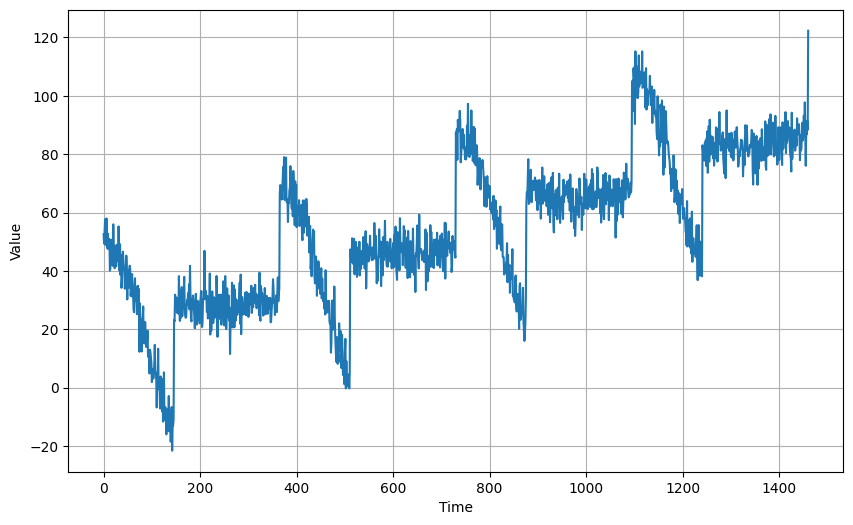

In [ ]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

Next up, you will split the data above into training and validation sets. You will take the first 1,000 points for training while the rest is for validation.

In [ ]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

You can inspect these sets visually by using the same utility function for plotting. Notice that in general, the validation set has higher values (i.e. y-axis) than those in the training set. Your model should be able to predict those values just by learning from the trend and seasonality of the training set.

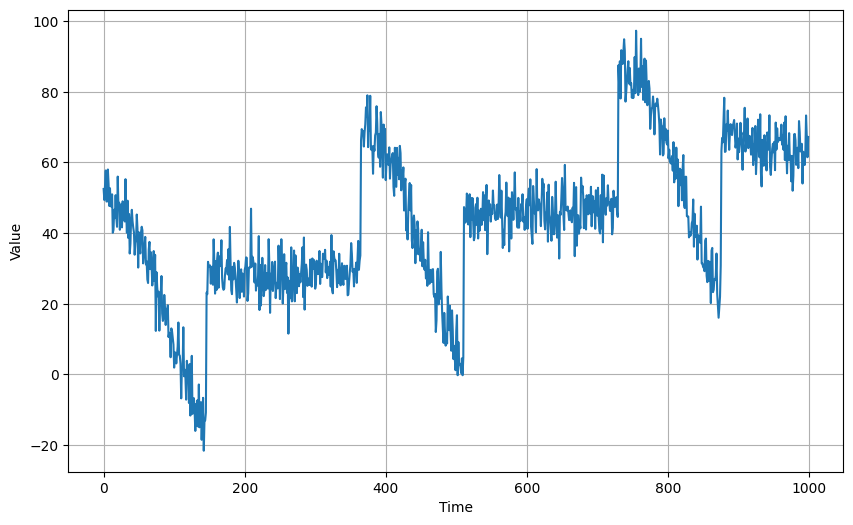

In [ ]:
# Plot the train set
plot_series(time_train, x_train)

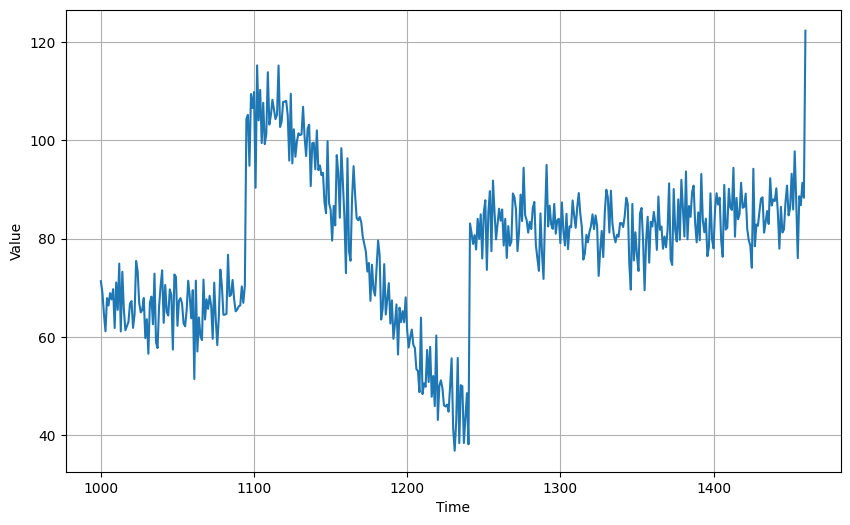

In [ ]:
# Plot the validation set
plot_series(time_valid, x_valid)

# Naive Forecast

As a baseline, you can do a naive forecast where you assume that the next value will be the same as the previous time step. You can slice the original series like below and print some values as a sanity check. The next time step value should be identical to the ground truth at the previous time step.

In [ ]:
# Generate the naive forecast
naive_forecast = series[split_time - 1:-1]

# Define time step
time_step = 100

# Print values
print(f'ground truth at time step {time_step}: {x_valid[time_step]}')
print(f'prediction at time step {time_step + 1}: {naive_forecast[time_step + 1]}')


ground truth at time step 100: 109.84197998046875
prediction at time step 101: 109.84197998046875


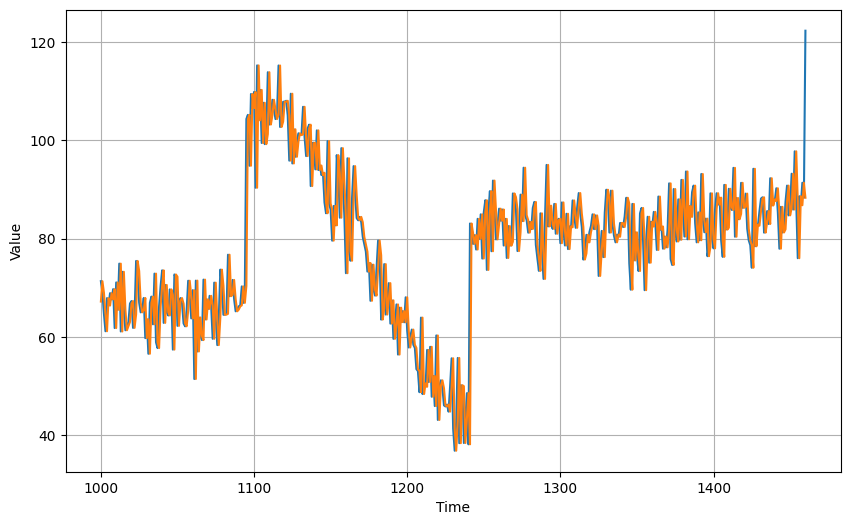

In [ ]:
# Plot the results
plot_series(time_valid, (x_valid, naive_forecast))

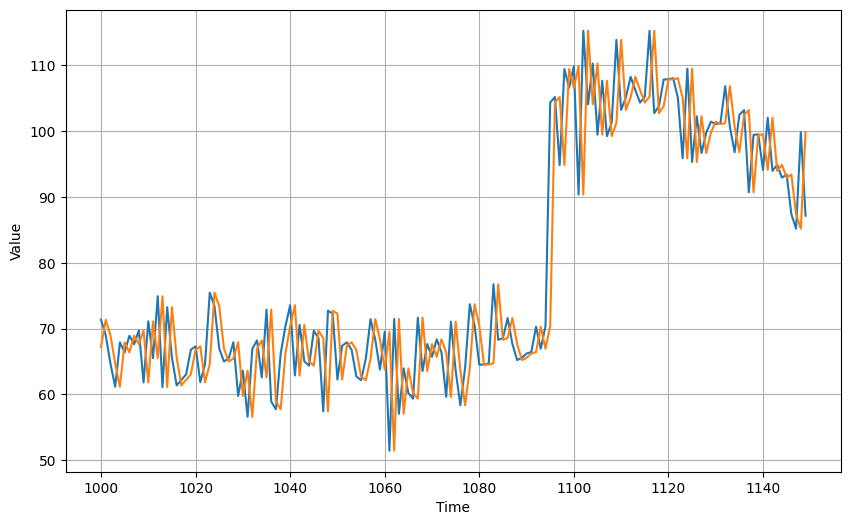

In [ ]:
# Zooming in
plot_series(time_valid, (x_valid, naive_forecast), start=0, end=150)

### Computing Metrics

Now you will compute the [mean squared error](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/mean_squared_error) and the [mean absolute error](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/mean_absolute_error) between the forecasts and the predictions in the validation period. These are available via the [`tf.keras.metrics`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/) API.

In [ ]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827534
5.937908


## Moving Average

One technique you can use is to do a moving average. This sums up a series of time steps and the average will be the prediction for the next time step. For example, the average of the measurements at time steps 1 to 10 will be the forecast for time step 11, then the average for time steps 2 to 11 will be the forecast for time step 12, and so on.

The function below does the moving average for the entire `series`. It takes a `window_size` argument to indicate the number of time steps to consider when computing the mean.

In [ ]:
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []

    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())

    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

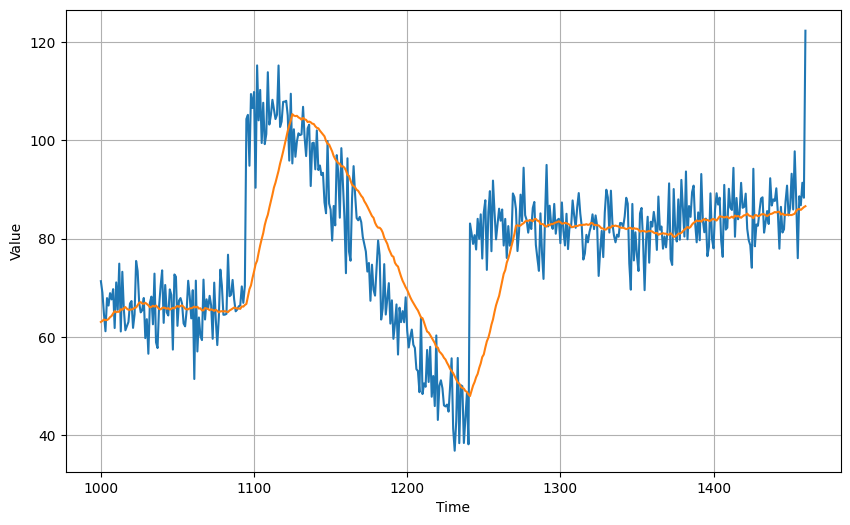

In [ ]:
## You will use this function to generate the forecast with a window size of `30`.
# Generate the moving average forecast
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

# Plot the results
plot_series(time_valid, (x_valid, moving_avg))

In [ ]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.142419


That's worse than naive forecast! The moving average does not anticipate trend or seasonality. In particular, those huge spikes in the original series causes big deviations as shown in the plot above. You will try to remove these characteristics of the dataset with time differencing and see if you get better results.

## Differencing

Since the seasonality period is 365 days, you will subtract the value at time *t* – 365 from the value at time *t*. That is done with the code below.

In addition, you will need to align the result with the `time` array. Since you can only do time differencing for `t >= 365`, you will need to truncate the first 365 time steps of the `time` array.

You can plot the result to visualize the values.

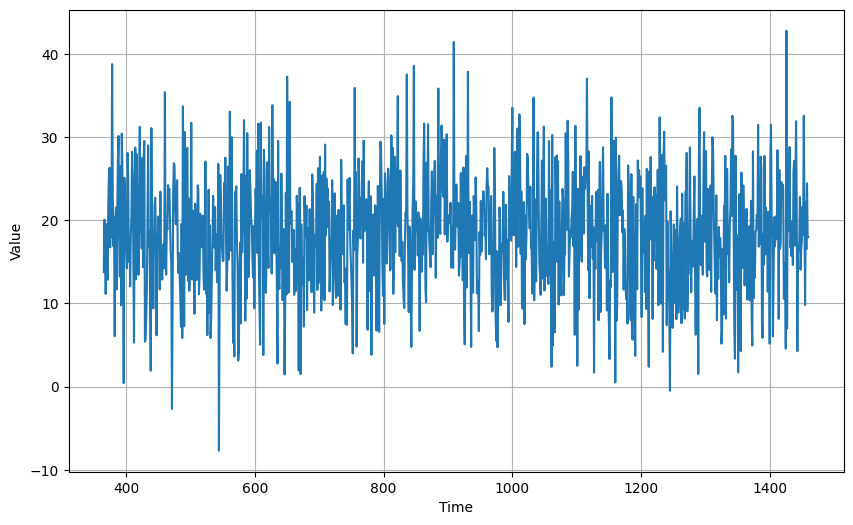

In [ ]:
# Subtract the values at t-365 from original series
diff_series = (series[365:] - series[:-365])

# Truncate the first 365 time steps
diff_time = time[365:]

# Plot the results
plot_series(diff_time, diff_series)

Great! The trend and seasonality seem to be gone so now you can retry using the moving average. `diff_series` is the ground truth while `diff_moving_avg` is the prediction array. You will slice these accordingly to correspond to the validation set time steps before comparing.

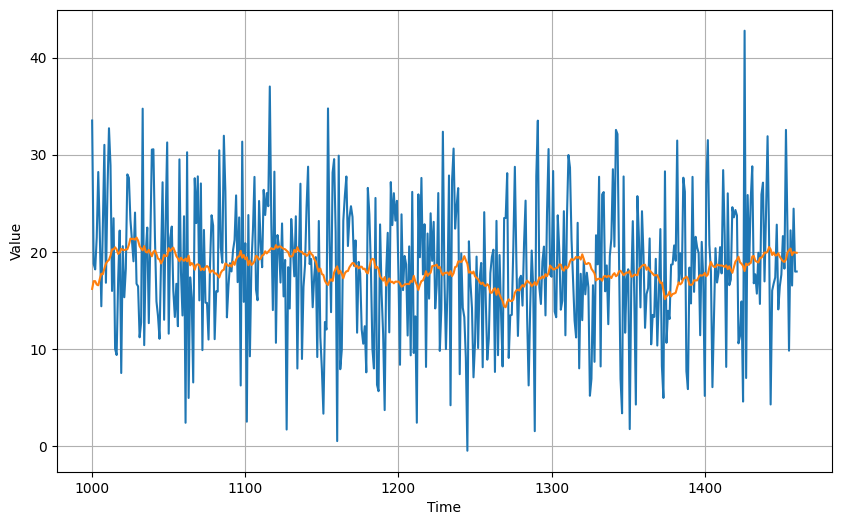

In [ ]:
# Generate moving average from the time differenced dataset
diff_moving_avg = moving_average_forecast(diff_series, 30)

# Slice the prediction points that corresponds to the validation set time steps
diff_moving_avg = diff_moving_avg[split_time - 365 - 30:]

# Slice the ground truth points that corresponds to the validation set time steps
diff_series = diff_series[split_time - 365:]

# Plot the results
plot_series(time_valid, (diff_series, diff_moving_avg))

Now you will bring bring back the trend and seasonality by adding the past values from `t – 365`:

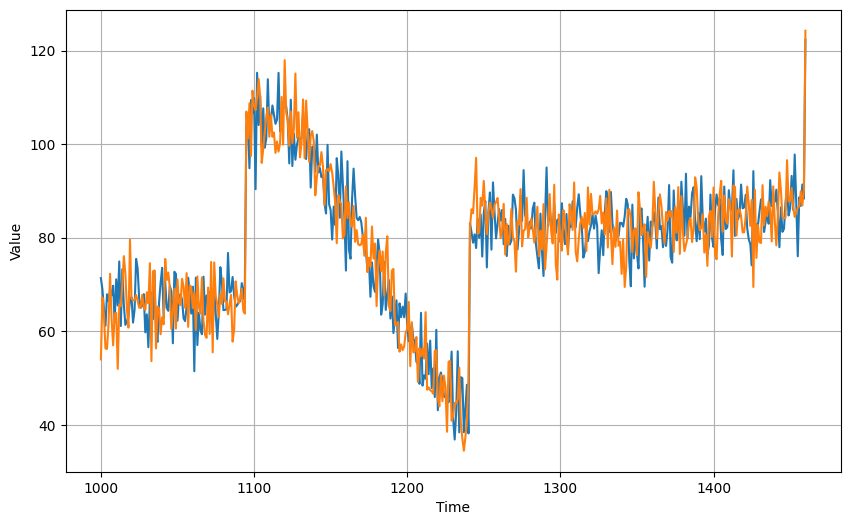

In [ ]:
# Add the trend and seasonality from the original series
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_past))

In [ ]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

53.764587
5.9032416


It is a bit better than naive forecast. However, the forecasts look a bit too random because you're adding past values which are already noisy. Remember that the time differenced signal is also noisy so adding these raw past values can compound this problem. To remedy that, you can use a moving averaging on past values to smooth out some of this noise.

## Smoothing

You can use the same `moving_average_forecast()` function to smooth out past values before adding them back to the time differenced moving average. There are two ways to do this:

* Trailing windows - This refers to getting the mean of past values to smooth out the value at the current time step. For example, getting the average of `t=0` to `t=6` to get the smoothed data point at **`t=6`**.

* Centered windows - This refers to getting the mean of past *and future* values to smooth out the value at the current time step. For example, getting the average of `t=0` to `t=6` to get the smoothed data point at **`t=3`**.

The code below will use the centered windows approach and you will notice it in the slicing of the `series` array. It is shifted by `370` steps and the window size is `11`. To get the smooth data point at `t=1000` (i.e. start of the validation set), it will average the measurements at `t=995` to `t=1005`.

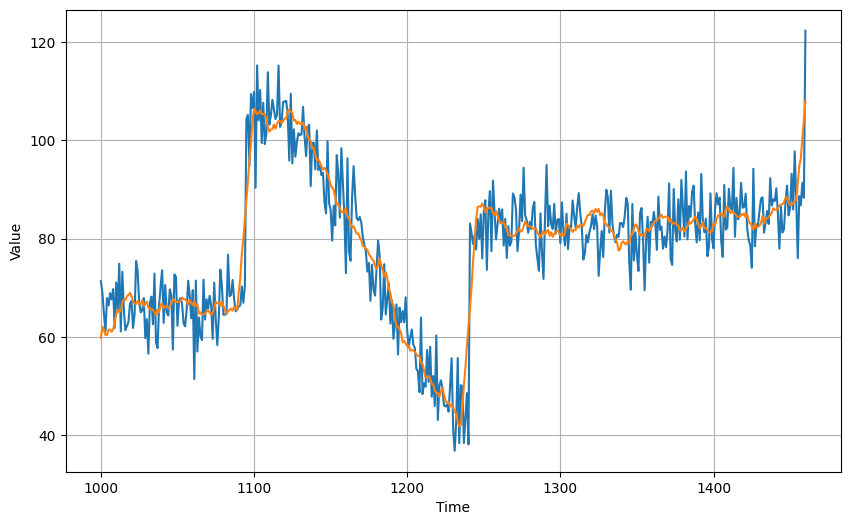

In [ ]:
# Smooth the original series before adding the time differenced moving average
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_smooth_past))

The metrics will show a big improvement over the previous output.

In [ ]:
 # Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

34.315723
4.6053295


## Wrap Up

This concludes a short exploration of statistical methods for time series forecasting. In the next labs, you will build neural networks for forecasting and see if you get comparable results to the techniques you just used in this lab.

------------------------------------------------------------------------------------------------------------

# Ungraded Lab: Preparing Time Series Features and Labels

In this lab, you will prepare time series data into features and labels that you can use to train a model. This is mainly achieved by a *windowing* technique where in you group consecutive measurement values into one feature and the next measurement will be the label. For example, in hourly measurements, you can use values taken at hours 1 to 11 to predict the value at hour 12. The next sections will show how you can implement this in Tensorflow.

Let's begin!

## Imports

Tensorflow will be your lone import in this module and you'll be using methods mainly from the [tf.data API](https://www.tensorflow.org/guide/data), particularly the [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) class. This contains many useful methods to arrange sequences of data and you'll see that shortly.

In [ ]:
import tensorflow as tf

## Create a Simple Dataset

For this exercise, you will just use a sequence of numbers as your dataset so you can clearly see the effect of each command. For example, the cell below uses the [range()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#range) method to generate a dataset containing numbers 0 to 9.

In [ ]:
# Generate a tf dataset with 10 elements
dataset = tf.data.Dataset.range(10)

# Preview the result
for val in dataset:
  print(val.numpy())

0
1
2
3
4
5
6
7
8
9


## Windowing the data

As mentioned earlier, you want to group consecutive elements of your data and use that to predict a future value. This is called windowing and you can use that with the [window()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) method as shown below. Here, you will take 5 elements per window (i.e. `size` parameter) and you will move this window 1 element at a time (i.e. `shift` parameter). One caveat to using this method is that each window returned is a [Dataset](https://www.tensorflow.org/guide/data#dataset_structure) in itself. This is a Python iterable and, as of the current version (TF 2.8), it won't show the elements if you use the `print()` method on it. It will just show a description of the data structure (e.g. `<_VariantDataset shapes: (), types: tf.int64>`).

In [ ]:
# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.range(10)

# Window the data
dataset = dataset.window(size=5, shift=1)

# Print the result
for window_dataset in dataset:
  print(window_dataset)

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


If you want to see the elements, you will have to iterate over each iterable. This can be done by modifying the print statement above with a nested for-loop or list comprehension. The code below shows the list comprehension while in the lecture video, you saw the for-loop.

In [ ]:
# Print the results
for window_dataset in dataset:
  print([item.numpy() for item in window_dataset])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]
[6, 7, 8, 9]
[7, 8, 9]
[8, 9]
[9]


Now that you can see the elements of each window, you'll notice that the resulting sets are not sized evenly because there are no more elements after the number `9`. You can use the `drop_remainder` flag to make sure that only 5-element windows are retained.

In [ ]:
# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.range(10)

# Window the data but only take those with the specified size
dataset = dataset.window(size = 5, shift = 1, drop_remainder = True)

# Print the result
for window_dataset in dataset:
  print([item.numpy() for item in window_dataset])


[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


## Flatten the Windows

In training the model later, you will want to prepare the windows to be [tensors](https://www.tensorflow.org/guide/tensor) instead of the `Dataset` structure. You can do that by feeding a mapping function to the [flat_map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#flat_map) method. This function will be applied to each window and the results will be [flattened into a single dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#flatten_a_dataset_of_windows_2). To illustrate, the code below will put all elements of a window into a single batch then flatten the result.

In [ ]:
# Generate a tf dataset with 10 elements
dataset = tf.data.Dataset.range(10)

#Window the data but only tae those with the specified size
dataset = dataset.window(5, shift = 1, drop_remainder = True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


## Group into features and labels

Next, you will want to mark the labels in each window. For this exercise, you will do that by splitting the last element of each window from the first four. This is done with the [map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) method containing a lambda function that defines the window slicing.

In [ ]:
# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.range(10)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift =1, drop_remainder = True)

# Flatten the windows by putting its elements in a single batch
dataset  = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features(first four elements of the window) & labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()

x =  [0 1 2 3]
y =  4

x =  [1 2 3 4]
y =  5

x =  [2 3 4 5]
y =  6

x =  [3 4 5 6]
y =  7

x =  [4 5 6 7]
y =  8

x =  [5 6 7 8]
y =  9



## Shuffle the data

It is good practice to shuffle your dataset to reduce *sequence bias* while training your model. This refers to the neural network overfitting to the order of inputs and consequently, it will not perform well when it does not see that particular order when testing. You don't want the sequence of training inputs to impact the network this way so it's good to shuffle them up.

You can simply use the [shuffle()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) method to do this. The `buffer_size` parameter is required for that and as mentioned in the doc, you should put a number equal or greater than the total number of elements for better shuffling. We can see from the previous cells that the total number of windows in the dataset is `6` so we can choose this number or higher.

In [ ]:
# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.range(10)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift = 1, drop_remainder = True)

# Flatten with windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) & labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# Shuffle the windows
dataset = dataset.shuffle(buffer_size = 10)

# Print the results
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()


x =  [1 2 3 4]
y =  5

x =  [3 4 5 6]
y =  7

x =  [0 1 2 3]
y =  4

x =  [4 5 6 7]
y =  8

x =  [2 3 4 5]
y =  6

x =  [5 6 7 8]
y =  9



## Create batches for training

Lastly, you will want to group your windows into batches. You can do that with the [batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) method as shown below. Simply specify the batch size and it will return a batched dataset with that number of windows. As a rule of thumb, it is also good to specify a [prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) step. This optimizes the execution time when the model is already training. By specifying a prefetch `buffer_size` of `1` as shown below, Tensorflow will prepare the next one batch in advance (i.e. putting it in a buffer) while the current batch is being consumed by the model. You can read more about it [here](https://towardsdatascience.com/optimising-your-input-pipeline-performance-with-tf-data-part-1-32e52a30cac4#Prefetching).

In [ ]:
# Generate a tf dataset with 10 elements
dataset = tf.data.Dataset.range(10)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift = 1, drop_remainder = True)

# Flatten the window by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features and labels
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# Shuffle the windows
dataset = dataset.shuffle(buffer_size = 10)

# Create batches of windows
dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()


x =  [[2 3 4 5]
 [0 1 2 3]]
y =  [6 4]

x =  [[1 2 3 4]
 [4 5 6 7]]
y =  [5 8]

x =  [[3 4 5 6]
 [5 6 7 8]]
y =  [7 9]



## Wrap Up

This short exercise showed you how to chain different methods of the `tf.data.Dataset` class to prepare a sequence into shuffled and batched window datasets. You will be using this same concept in the next exercises when you apply it to synthetic data and use the result to train a neural network. On to the next!

---------------------------------------------------------------------------------------------------------------------------

# Ungraded Lab: Training a Single Layer Neural Network with Time Series Data

Now that you've seen statistical methods in the previous week, you will now shift to using neural networks to build your prediction models. You will start with a simple network in this notebook and move on to more complex architectures in the next weeks. By the end of this lab, you will be able to:

* build a single layer network and train it using the same synthetic data you used in the previous lab
* prepare time series data for training and evaluation
* measure the performance of your model against a validation set

## Imports

You will first import the packages you will need to execute all the code in this lab. You will use:
* [Tensorflow](https://www.tensorflow.org/api_docs/python/tf) to build your model and prepare data windows
* [Numpy](https://numpy.org/) for numerical processing
* and Matplotlib's [PyPlot](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.html) library for visualization

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

You will then define some utility functions that you also saw in the previous labs. These will take care of visualizing your time series data and model predictions, as well as generating the synthetic data.

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Generate the Synthetic Data

The code below generates the same synthetic data you used in the previous lab. It will contain 1,461 data points that has trend, seasonality, and noise.

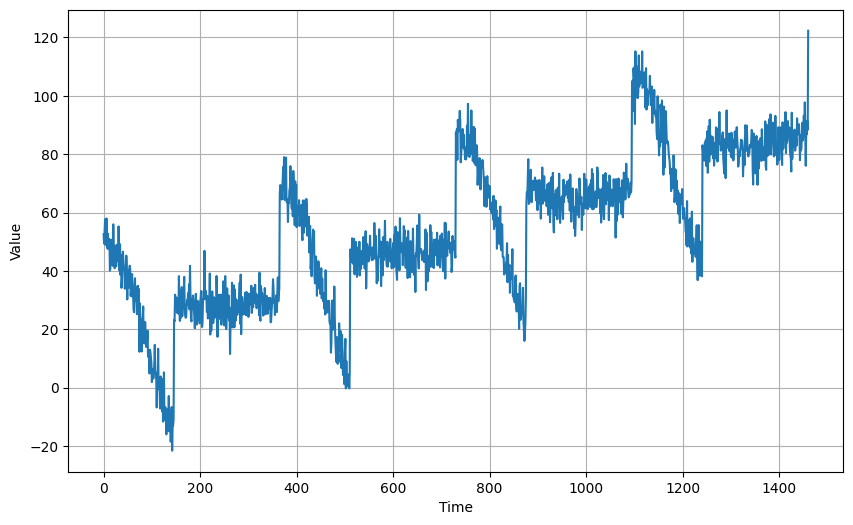

In [ ]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

Next up, you will split the data above into training and validation sets. You will take the first 1,000 points for training while the rest is for validation,

In [ ]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

You can inspect these sets visually by using the same utility function for plotting. Notice that in general, the validation set has higher values (i.e. y-axis) than those in the training set. Your model should be able to predict those values just by learning from the trend and seasonality of the training set.

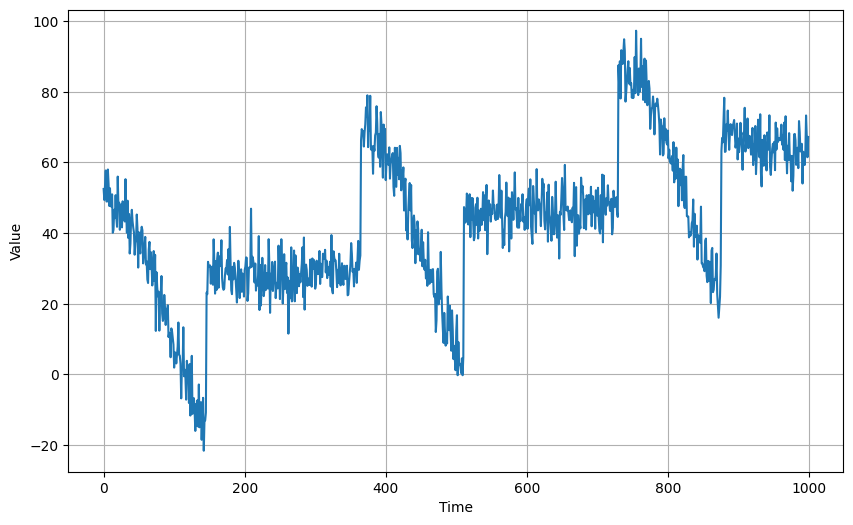

In [ ]:
# Plot the train set
plot_series(time_train, x_train)

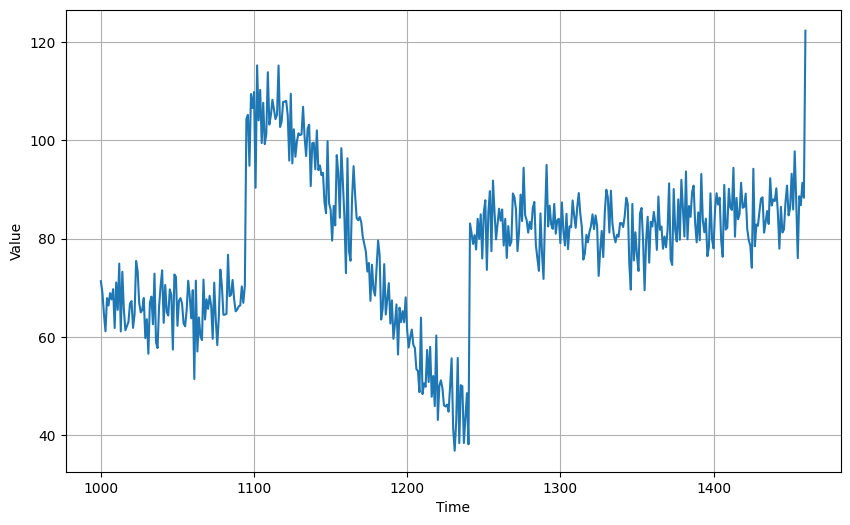

In [ ]:
# Plot the validation set
plot_series(time_valid, x_valid)

## Prepare features and labels

You will then prepare your data windows as shown in the previous lab. It is good to declare parameters in a separate cell so you can easily tweak it later if you want.

In [ ]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

The following function contains all the preprocessing steps you did in the previous lab. This makes it modular so you can easily use it in your other projects if needed.

One thing to note here is the `window_size + 1` when you call `dataset.window()`. There is a `+ 1` to indicate that you're taking the next point as the label. For example, the first 20 points will be the feature so the 21st point will be the label.

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """
  Generates dataset windows
  series (array of float) - contains the values of the time series
  window_size (int) - the number of time steps to include in the feature
  batch_size (int) - the batch size
  shuffle_buffer (int) - buffer size to use for the shuffle method

  Returns: dataset (TF dataset)
  """

  # Generate a TF data from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data but only take those with specified size
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # Create tuples with features and labels
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  # Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


Now you can generate the dataset windows from the train set.

In [ ]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

You can again inspect the output to see if the function is behaving as expected. The code below will use the [`take()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) method of the `tf.data.Dataset` API to grab a single batch. It will then print several properties of this batch such as the data type and shape of the elements. As expected, it should have a 2-element tuple (i.e. `(feature, label)`) and the shapes of these should align with the batch and window sizes you declared earlier which are `32` and `20` by default, respectively.

In [ ]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element (32,)


## Build and compile the model

Next, you will build the single layer neural network. This will just be a one-unit [Dense](https://keras.io/api/layers/core_layers/dense/) layer as shown below. You will assign the layer to a variable `l0` so you can also look at the final weights later using the [`get_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#get_weights) method.

In [ ]:
# Build the single layer neural network
l0 = tf.keras.layers.Dense(1, input_shape = [window_size])
model = tf.keras.models.Sequential([l0])

# Print the initial layer weights
print(f"Layer weights : \n {l0.get_weights()}")

model.summary()

Layer weights : 
 [array([[-0.23244461],
       [ 0.35754436],
       [-0.16337308],
       [-0.3166448 ],
       [-0.06754145],
       [-0.5170418 ],
       [ 0.35104722],
       [-0.34741965],
       [-0.50713205],
       [ 0.25083154],
       [ 0.00222689],
       [-0.25971398],
       [-0.14895287],
       [-0.20975608],
       [-0.34342247],
       [ 0.41370445],
       [-0.09035718],
       [-0.21298921],
       [ 0.14406055],
       [-0.12118825]], dtype=float32), array([0.], dtype=float32)]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


You will set [*mean squared error (mse)*](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError) as the loss function and use [*stochastic gradient descent (SGD)*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) to optimize the weights during training.

In [ ]:
# Set the training parameters
model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.SGD(
                  learning_rate = 1e-6, momentum = 0.9
              )
              )

## Train the Model

Now you can proceed to train your model. You will feed in the prepared data windows and run the training for 100 epochs.

In [ ]:
# Train the model
model.fit(dataset, epochs = 100)

Epoch 1/100
31/31 [==============================] - 1s 6ms/step - loss: 3567.8125
Epoch 2/100
31/31 [==============================] - 1s 7ms/step - loss: 219.3932
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 97.3036
Epoch 4/100
31/31 [==============================] - 1s 4ms/step - loss: 86.6246
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 84.9921
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 83.0537
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 79.8733
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 78.3118
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 76.3824
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 75.7021
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 75.1257
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 72.8677
Epoch 13/100
31/31 [==

You can see the final weights by again calling the `get_weights()` method.

In [ ]:
# Print the layer weights
print("layer weights {}".format(l0.get_weights()))

layer weights [array([[-0.07673851],
       [ 0.07238623],
       [ 0.0233271 ],
       [-0.04462942],
       [ 0.02868404],
       [-0.04453347],
       [ 0.0899239 ],
       [-0.0234436 ],
       [-0.09196898],
       [ 0.08944779],
       [ 0.02066813],
       [-0.02502812],
       [-0.04512322],
       [ 0.02333655],
       [-0.02267657],
       [ 0.1455129 ],
       [ 0.02218792],
       [ 0.12224952],
       [ 0.30995944],
       [ 0.42780584]], dtype=float32), array([0.01665333], dtype=float32)]


## Model Prediction

With the training finished, you can now measure the performance of your model. You can generate a model prediction by passing a batch of data windows. If you will be slicing a window from the original `series` array, you will need to add a batch dimension before passing it to the model. That can be done by indexing with the [`np.newaxis`](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis) constant or using the [`np.expand_dims()`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) method.

In [ ]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaixs]: {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis = 0).shape}')

# Sample model Prediction
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaixs]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 [==============================] - 0s 128ms/step
model prediction: [[44.84782]]


To compute the metrics, you will want to generate model predictions for your validation set. Remember that this set refers to points at index `1000` to `1460` of the entire series. You will need to code the steps to generate those from your model. The cell below demonstrates one way of doing that.

Basically, it feeds the entire series to your model 20 points at a time and append all results to a `forecast` list. It will then slice the points that corresponds to the validation set.

The slice index below is `split_time - window_size:` because the forecast list is smaller than the series by 20 points (i.e. the window size). Since the window size is 20, the first data point in the `forecast` list corresponds to the prediction for time at index `20`. You cannot make predictions at index `0` to `19` because those are smaller than the window size. Thus, when you slice with `split_time - window_size:`, you will be getting the points at the time indices that aligns with those in the validation set.

*Note: You might notice that this cell takes a while to run. In the next two labs, you will see other approaches to generating predictions to make the code run faster. You might already have some ideas and feel free to try them out after completing this lab.*

In [ ]:
# Initialize a list
forecast = []

# use the model to predict data points per window size
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time: time + window_size][np.newaxis]))

# Slice the points that are aligned with the validation set
forecast  = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

1/1 [==============================] - 0s 19ms/step
length of the forecast list: 461
shape of the validation set: (461,)


To visualize the results, you will need to convert the predictions to a form that the `plot_series()` utility function accepts. That involves converting the list to a numpy array and dropping the single dimensional axes.

shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


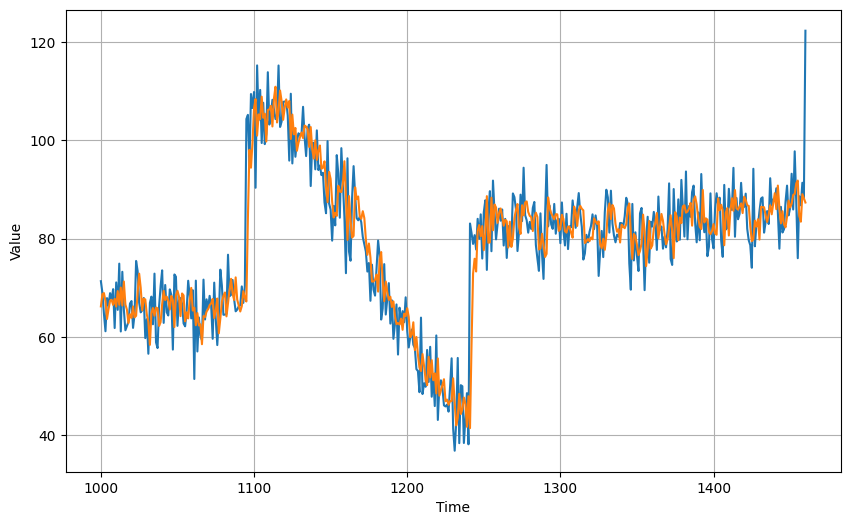

In [ ]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results))

You can compute the metrics by calling the same functions as before. You will get an MAE close to 5.

In [ ]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

47.02232
5.0821614


## Wrap Up

In this lab, you were able to build and train a single layer neural network on time series data. You prepared data windows, fed them to the model, and the final predictions show comparable results with the statistical analysis you did in Week 1. In the next labs, you will try adding more layers and will also look at some optimizations you can make when training your model.

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Ungraded Lab: Training a Deep Neural Network with Time Series Data

In this lab, you will build upon the previous exercise and add more dense layers to your network. You will also look at a technique to tune the model's learning rate to make the weights converge faster. This is a useful tip so you can avoid guessing the learning rate before training.

The initial steps will be identical to the previous lab so you can run the next cells until the `Build the Model` section. That's where the discussions begin.

## Imports

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

In [ ]:
def plot_series(time, series, format = '-', start = 0, end = None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup the dimensions of the graph figure
    plt.figure(figsize = (10,6))

    if type(series) is tuple:
      for series_num in series:
        #Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel('Time')
    plt.ylabel('Value')

    # Grid
    plt.grid(True)

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Generate the Synthetic Data

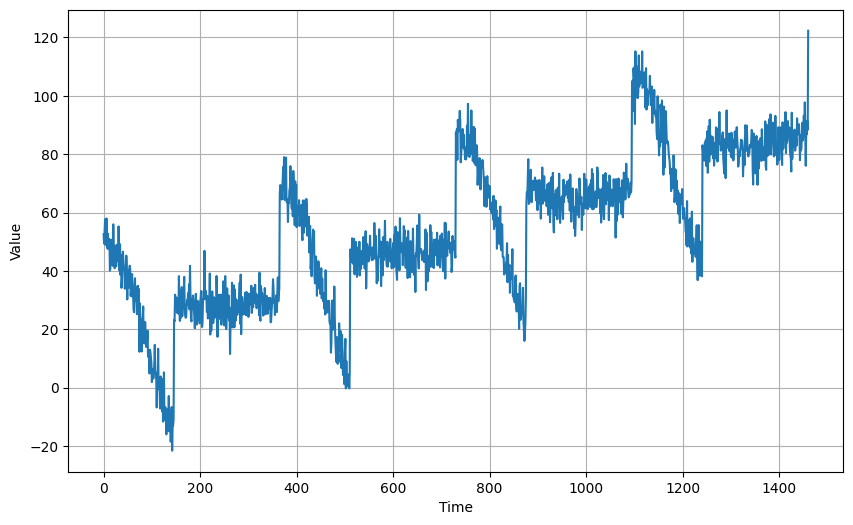

In [ ]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [ ]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [ ]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size +1, shift = 1, drop_remainder = True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size +1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window : (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

You will use three dense layers in this exercise as shown below. As expected, the number of trainable parameters will increase and the model summary shows that it is more than tenfold of the previous lab.

In [ ]:
# Build the model

model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

# Print the model Summary
model_baseline.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                210       
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train the Model

You will then compile and train the model using the same settings as before. Observe how the loss is decreasing because you will revisit it later in this lab.

In [ ]:
# Set the training parameters
model_baseline.compile(
    loss = 'mse',
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 1e-6, momentum = 0.9
    )
)

In [ ]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
# Train the model
model_baseline.fit(dataset, epochs = 100)

Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 224.7881
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 124.5096
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 110.6862
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 102.3828
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 96.6510
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 91.5517
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 87.0250
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 84.0022
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 81.1913
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 79.5018
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 77.3107
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 76.7296
Epoch 13/100
31/31 [=

You can then get some predictions and visualize it as before. Since the network is deeper, the predictions might go slower so you may want to minimize unnecessary computations.

In the previous lab, you might remember the model generating predictions using the entire `series` data. That resulted in 1,441 points in the `forecast` list then you sliced the 461 points that aligns with the validation set using `forecast = forecast[split_time - window_size:]`.

You can make this process faster by just generating 461 points right from the start. That way, you don't waste time predicting points that will just be thrown away later. The code below will do just that. It will just get the points needed from the original `series` before calling the `predict()` method. With that, all predictions will align with the validation set already and the for-loop will run for only 461 times instead of 1,441.

In the next lab, you'll see an even faster way to generate these predictions.

1/1 [==============================] - 0s 31ms/step


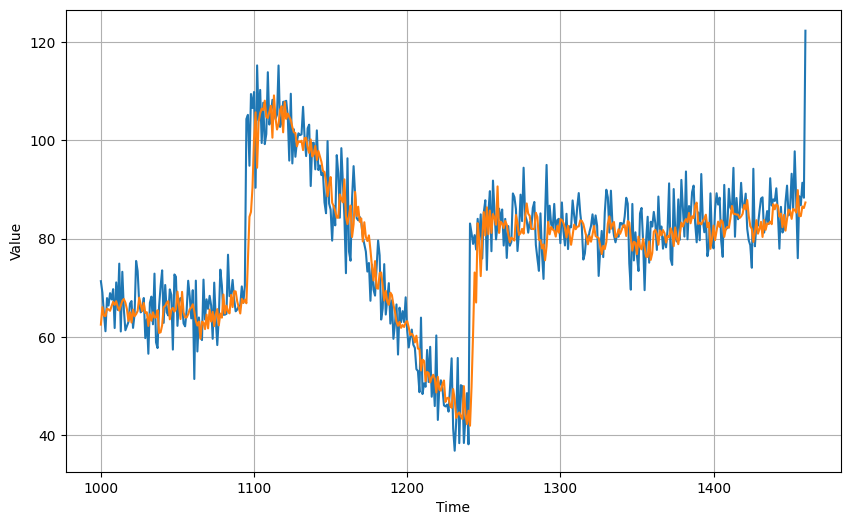

In [ ]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_baseline.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then get the MSE and MAE for reference.

In [ ]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

47.92195
4.90845


## Tune the learning rate

You saw that the training went well with the initial learning rate that you chose (i.e. `1e-6`). However, you're not yet sure if it is the best setting for this particular model. It might seem inconsequential in this simple model but when you have more complex ones, spending some time to tune the learning rate can lead to better training results. You will see how to do that in this section.

First, you will build the same model architecture you just used.

In [ ]:
# Build the model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

Next, you will declare a [learning rate scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) callback. This will allow you to dynamically set the learning rate based on the epoch number during training. As shown below, you will pass a lambda function to declare the value of the learning rate. It will start at `1e-8` at epoch 0 and is scaled by `10**(epoch / 20)` as the training goes on.

In [ ]:
# Set learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

You will then compile the model. Just to note a subtle difference with the lecture video, you don't have to set the `learning_rate` argument of the optimizer here before compiling. You can just leave the default (i.e. [`0.01` for SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD#args)) and allow the learning rate scheduler to set it dynamically.

In [ ]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

You will pass in the `lr_schedule` callback in the `callbacks` parameter of the [`fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. As you run the training below, you will see the learning rate at a particular epoch denoted by `lr` in the console output. Notice that it is increasing as expected based on the lambda function you used.

In [ ]:
# Train the model
history = model_tune.fit(
    dataset, epochs = 100, callbacks = [lr_schedule]
)

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 2000.1991 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 1632.4178 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 1258.5702 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 932.6978 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 671.3727 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 475.5603 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 348.2350 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 275.8421 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 238.5320 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 223.2683 - lr: 2.8184e-08
Epoch 

Next step is to plot the results of the training. You will visualize the loss at each value of the learning rate.

(1e-08, 0.001, 0.0, 300.0)

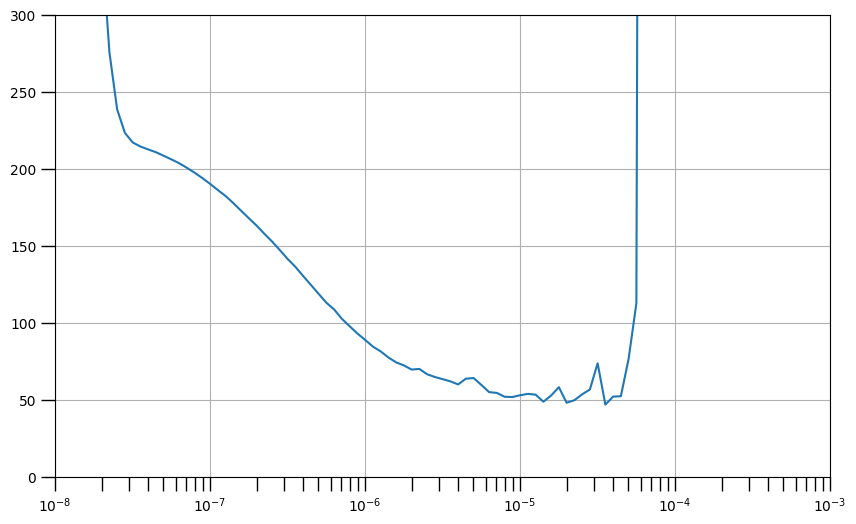

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

The generated graph above shows the values of the range of learning rates that leads to lower losses (i.e. sloping downward) and also which ones cause the training to become unstable (i.e. jagged edges and pointing upwards). In general, you will want to pick a point in a downward slope. That means the network is still learning at that point and is stable. Choosing close to the minimum point of the graph will make the training converge to that loss value quicker, as will be shown in the next cells.

First, you will initialize the same model architecture again.

In [ ]:
# Build the model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation = 'relu', input_shape = [window_size]),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

You will then set the optimizer with a learning rate close to the minimum. It is set to `4e-6` initially but feel free to change based on your results.

In [ ]:
# Set teh optimizer with the tune learning rate
optimizer = tf.keras.optimizers.SGD(
    learning_rate = 4e-6, momentum = 0.9
)

You can then compile and train the model as before. Observe the loss values and compare it to the output of the baseline model you had before. Most likely, you will have met the final loss value of the `model_baseline` within the first 50 epochs of training this `model_tune`. You will also likely have a lower loss after all 100 epochs are done.

In [ ]:
# Set the training parameters
model_tune.compile(
    loss = 'mse', optimizer = optimizer
)

# Train the model
history = model_tune.fit(dataset, epochs = 100)

Epoch 1/100
31/31 [==============================] - 2s 5ms/step - loss: 130.4807
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 88.0688
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 80.6501
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 74.5878
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 68.7479
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 59.8558
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 58.6470
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 55.3986
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 53.0815
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 53.5823
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 55.5709
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 53.3017
Epoch 13/100
31/31 [====

You can plot the `loss` values by getting it from the [History](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) object returned by the `fit()` method. As you can see, the model is still trending downward after the training.

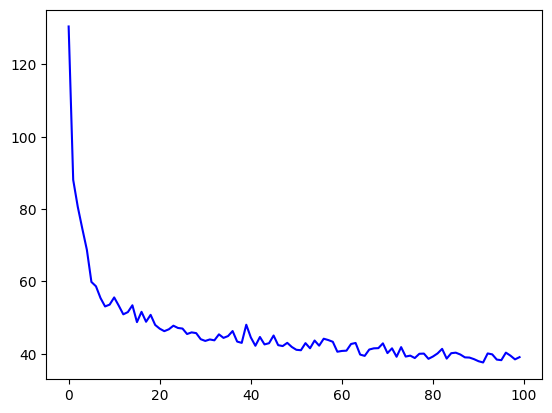

In [ ]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

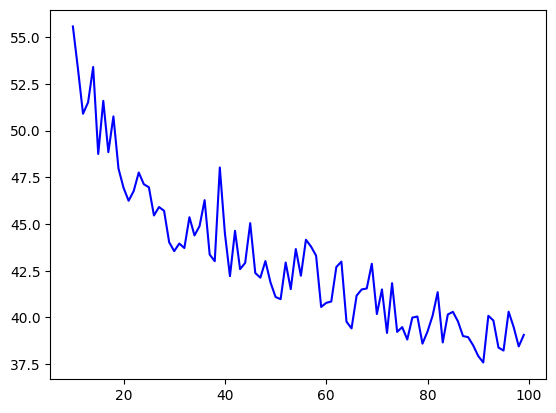

In [ ]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

You can get the predictions again and overlay it on the validation set.

1/1 [==============================] - 0s 20ms/step


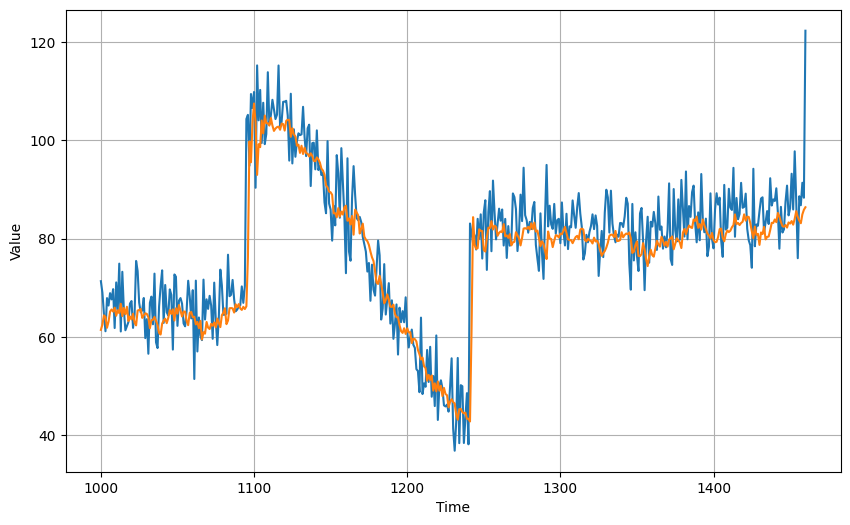

In [ ]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

Finally, you can compute the metrics and you should arrive at similar figures compared to the baseline. If it is much worse, then the model might have overfitted and you can use techniques you know to avoid it (e.g. adding dropout).

In [ ]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

45.67259
4.962377


## Wrap Up

This concludes the exercise on using a deep neural network for forecasting. Along the way, you did some hyperparameter tuning, particularly on the learning rate. You will be using this technique as well in the next labs. Next week, you will be using recurrent neural networks to build your forecasting model. See you there and keep it up!

--------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Ungraded Lab: Using a Simple RNN for forecasting

In this lab, you will start to use recurrent neural networks (RNNs) to build a forecasting model. In particular, you will:

* build a stacked RNN using `simpleRNN` layers
* use `Lambda` layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions

You will train this on the same synthetic dataset from last week so the initial steps will be the same. Let's begin!

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Generate the Synthetic Data

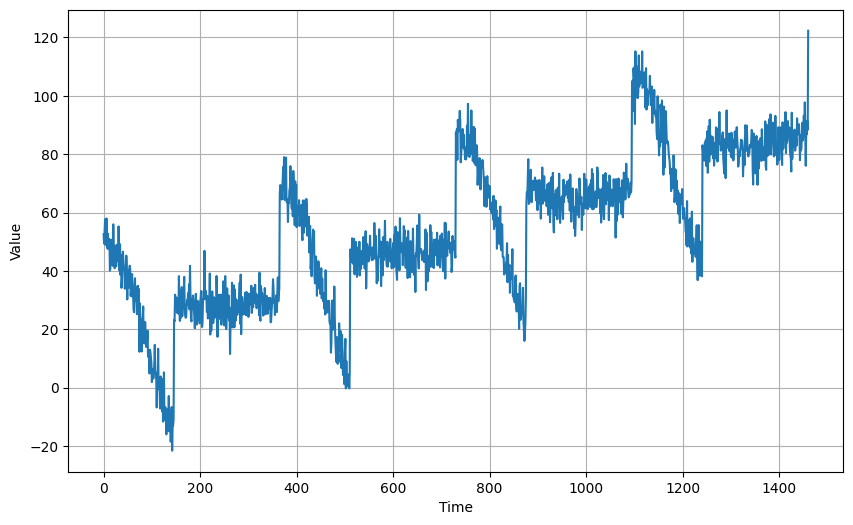

In [ ]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [ ]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [ ]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the Series Values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size +1, shift = 1, drop_remainder = True)

    # Flatten the windows by puttung its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create a tuples with features and labels
    dataset  = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


## Build the Model

Your model is composed mainly of [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) layers. As mentioned in the lectures, this type of RNN simply routes its output back to the input. You will stack two of these layers in your model so the first one should have `return_sequences` set to `True`.

As mentioned in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN#call_arguments), `SimpleRNN` layers expect a 3-dimensional tensor input with the shape `[batch, timesteps, feature`]. With that, you need to reshape your window from `(32, 20)` to `(32, 20, 1)`. This means the 20 datapoints in the window will be mapped to 20 timesteps of the RNN. You can do this reshaping in a separate cell but you can also do this within the model itself by using [Lambda](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) layers. Notice the first layer below. It defines a lambda function that adds a dimension at the last axis of the input. That's exactly the transformation you need. For the `input_shape`, you can specify `None` (like in the lecture video) if you want the model to be more flexible with the number of timesteps. Alternatively, you can set it to `window_size` as shown below if you want to set the `timesteps` dimension to the expected size of your data windows.

Normally, you can just a have a `Dense` layer output as shown in the previous labs. However, you can help the training by scaling up the output to around the same figures as your labels. This will depend on the [activation functions](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) you used in your model. `SimpleRNN` uses *tanh* by default and that has an output range of `[-1,1]`. You will use another `Lambda()` layer to scale the output by 100 before it adjusts the layer weights. Feel free to remove this layer later after this lab and see what results you get.

In [ ]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(
        lambda x: tf.expand_dims(x, axis = -1), input_shape = [window_size]
    ),
    tf.keras.layers.SimpleRNN(40, return_sequences = True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4961 (19.38 KB)
Trainable params: 4961 (19.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Tune the Learning Rate

You will then tune the learning rate as before. You will define a learning rate schedule that changes this hyperparameter dynamically. You will use the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss) as your loss function to minimize sensitivity to outliers.

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

# Set the training parameters
model_tune.compile(
    loss = tf.keras.losses.Huber(), optimizer = optimizer
)

# Train the model
history = model_tune.fit(dataset, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
31/31 [==============================] - 2s 14ms/step - loss: 103.8050 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 101.0404 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 97.6397 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 93.7260 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 89.2470 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 19ms/step - loss: 83.9868 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 20ms/step - loss: 77.8399 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 12ms/step - loss: 70.5231 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 11ms/step - loss: 61.5248 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 12ms/step - loss: 50.3643 - lr: 2.8184e-08
Epoch 1

You can visualize the results and pick an optimal learning rate.

(1e-08, 0.001, 0.0, 50.0)

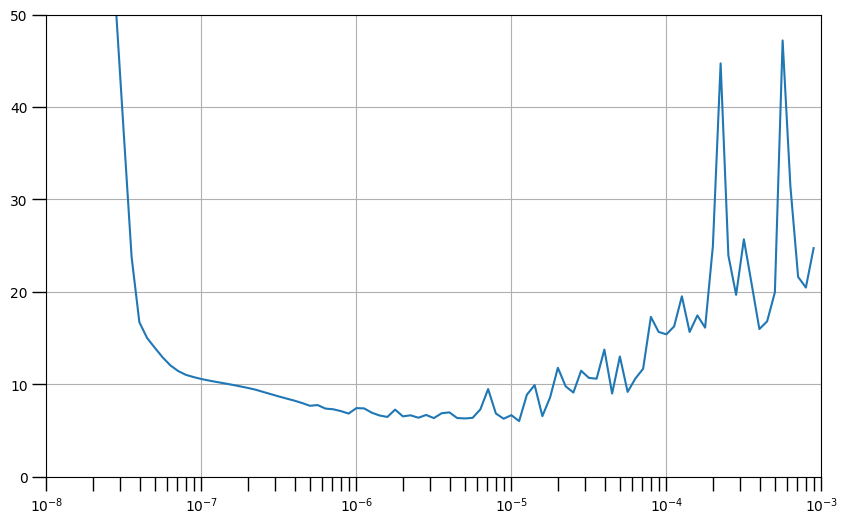

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

You can change the boundaries of the graph if you want to zoom in. The cell below chooses a narrower range so you can see more clearly where the graph becomes unstable.

(1e-07, 0.0001, 0.0, 20.0)

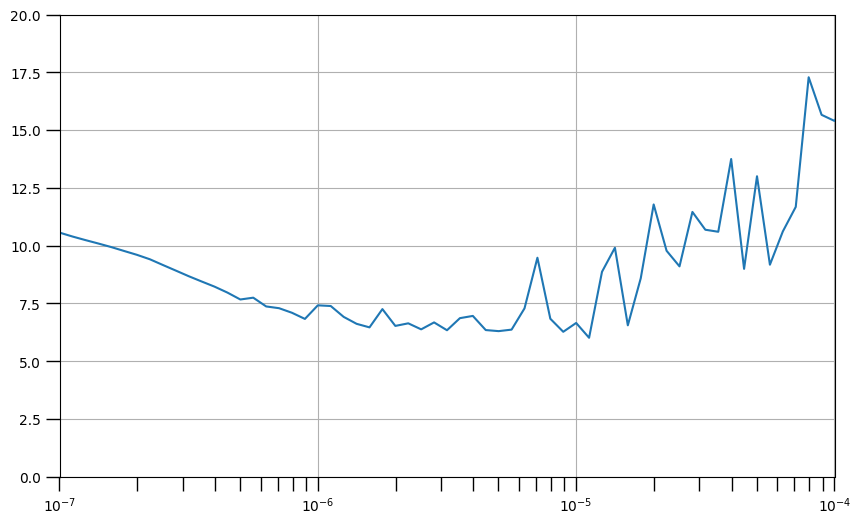

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20])

## Train the Model

You can then declare the model again and train with the learning rate you picked. It is set to `1e-6`by default but feel free to change it.

In [ ]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(
        lambda x: tf.expand_dims(x, axis = -1), input_shape = [window_size]
    ),
    tf.keras.layers.SimpleRNN(40, return_sequences = True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set learning rate
learning_rate = 1e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

# Set the training parameters
model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ['mae']
)

# Train the model
history = model.fit(dataset, epochs = 100)

Epoch 1/100
31/31 [==============================] - 7s 31ms/step - loss: 34.3399 - mae: 34.8359
Epoch 2/100
31/31 [==============================] - 1s 22ms/step - loss: 14.7712 - mae: 15.2586
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 10.7617 - mae: 11.2426
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 9.6711 - mae: 10.1520
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 9.1498 - mae: 9.6320
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 8.9534 - mae: 9.4367
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 8.6306 - mae: 9.1081
Epoch 8/100
31/31 [==============================] - 0s 12ms/step - loss: 8.2758 - mae: 8.7567
Epoch 9/100
31/31 [==============================] - 1s 16ms/step - loss: 8.0705 - mae: 8.5494
Epoch 10/100
31/31 [==============================] - 1s 20ms/step - loss: 7.8744 - mae: 8.3563
Epoch 11/100
31/31 [======================

## Model Prediction

Now it's time to generate the model predictions for the validation set time range. The model is a lot bigger than the ones you used before and the sequential nature of RNNs (i.e. inputs go through a series of time steps as opposed to parallel processing) can make predictions a bit slow. You can observe this when using the code you ran in the previous lab. This will take about a minute to complete.

In [ ]:
split_time

1000

0
20
len  20
1/1 [==============================] - 0s 39ms/step
1
21
len  20
1/1 [==============================] - 0s 37ms/step
2
22
len  20
1/1 [==============================] - 0s 37ms/step
3
23
len  20
1/1 [==============================] - 0s 38ms/step
4
24
len  20
1/1 [==============================] - 0s 36ms/step
5
25
len  20
1/1 [==============================] - 0s 58ms/step
6
26
len  20
1/1 [==============================] - 0s 60ms/step
7
27
len  20
1/1 [==============================] - 0s 43ms/step
8
28
len  20
1/1 [==============================] - 0s 58ms/step
9
29
len  20
1/1 [==============================] - 0s 38ms/step
10
30
len  20
1/1 [==============================] - 0s 89ms/step
11
31
len  20
1/1 [==============================] - 0s 52ms/step
12
32
len  20
1/1 [==============================] - 0s 76ms/step
13
33
len  20
1/1 [==============================] - 0s 89ms/step
14
34
len  20
1/1 [==============================] - 0s 91ms/step
15
35
len  20
1/1 [=

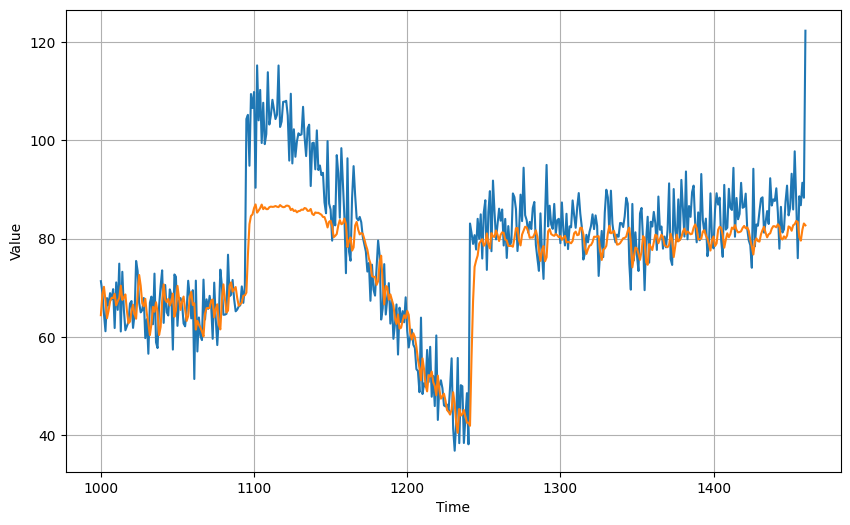

In [ ]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  print(time)
  print(time + window_size)
  print('len ',len(forecast_series[time:time + window_size]))
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can optimize this step by leveraging Tensorflow models' capability to process batches. Instead of running the for-loop above which processes a single window at a time, you can pass in an entire batch of windows and let the model process that in parallel.

The function below does just that. You will notice that it almost mirrors the `windowed_dataset()` function but it does not shuffle the windows. That's because we want the output to be in its proper sequence so we can compare it properly to the validation set.

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

You can run the function below to use the function. Notice that the predictions are generated almost instantly.

*Note: You might notice that the first line slices the `series` at `split_time - window_size:-1` which is a bit different from the slower for-loop code. That is because we want the model to have its last prediction to align with the last point of the validation set (i.e. `t=1460`). You were able to do that with the slower for-loop code by specifying the for-loop's `range()`. With the more efficient function above, you don't have that mechanism so you instead just remove the last point when slicing the `series`. If you don't, then the function will generate a prediction at `t=1461` which is outside the validation set range.*

15/15 [==============================] - 1s 13ms/step


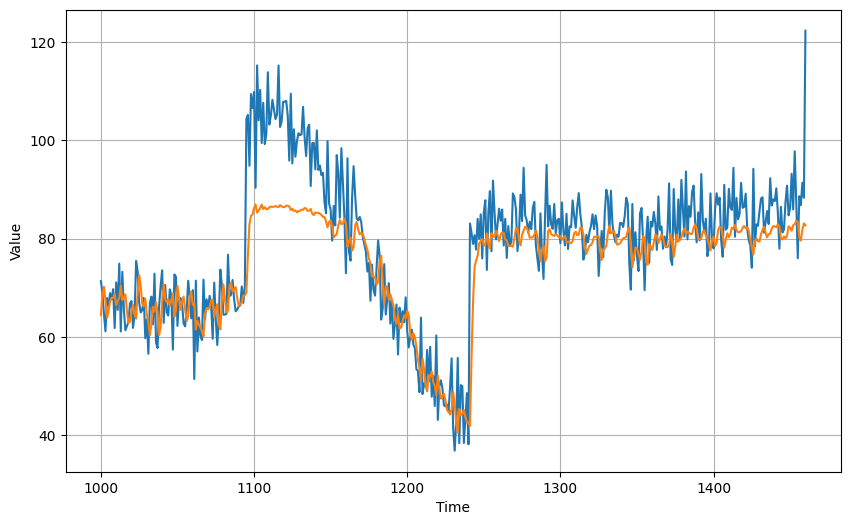

In [ ]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then compute the MSE and MAE. You can compare the results here when using other RNN architectures which you'll do in the next lab.

In [ ]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

79.30818
6.4217954


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Ungraded Lab: Using a multi-layer LSTM for forecasting

In this lab, you will use the same RNN architecure in the first lab but will instead stack [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers instead of `SimpleRNN`.

## Imports

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Generate the Synthetic Data

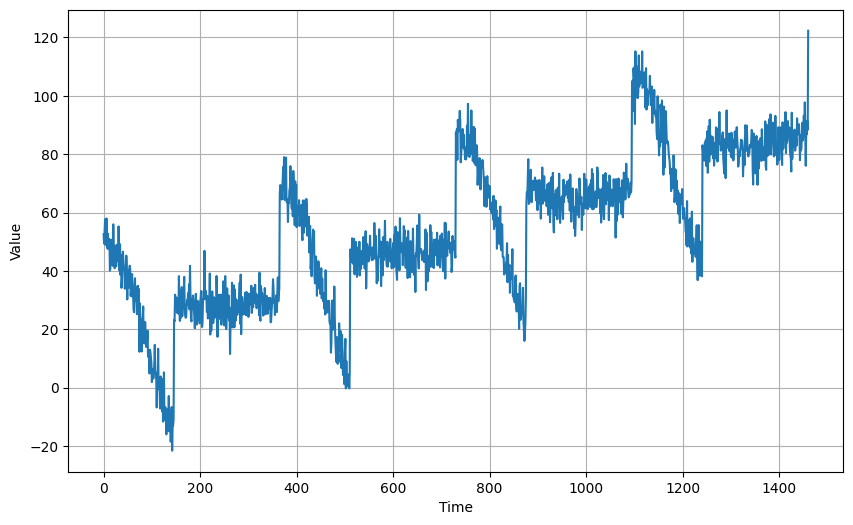

In [ ]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [ ]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [ ]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

As mentioned, you will swap `SimpleRNN` for `LSTM` in this lab. It is also set as bidirectional below but feel free to revise later and see what results you get. LSTMs are much more complex in their internal architecture than simpleRNNs. It implements a cell state that allows it to remember sequences better than simple implementations. This added complexity results in a bigger set of parameters to train and you'll see that when you print the model summary below.

In [ ]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis  = -1), input_shape = [window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 20, 64)            8704      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33601 (131.25 KB)
Trainable params: 33601 

## Tune the Learning Rate

As usual, you will pick a learning rate by running the tuning code below.

Epoch 1/100
31/31 [==============================] - 9s 37ms/step - loss: 12.0316 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 2s 42ms/step - loss: 11.9264 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 27ms/step - loss: 11.8072 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 27ms/step - loss: 11.6876 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 27ms/step - loss: 11.5664 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 28ms/step - loss: 11.4480 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 2s 51ms/step - loss: 11.3296 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 28ms/step - loss: 11.2153 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 27ms/step - loss: 11.0931 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 27ms/step - loss: 10.9719 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 30.0)

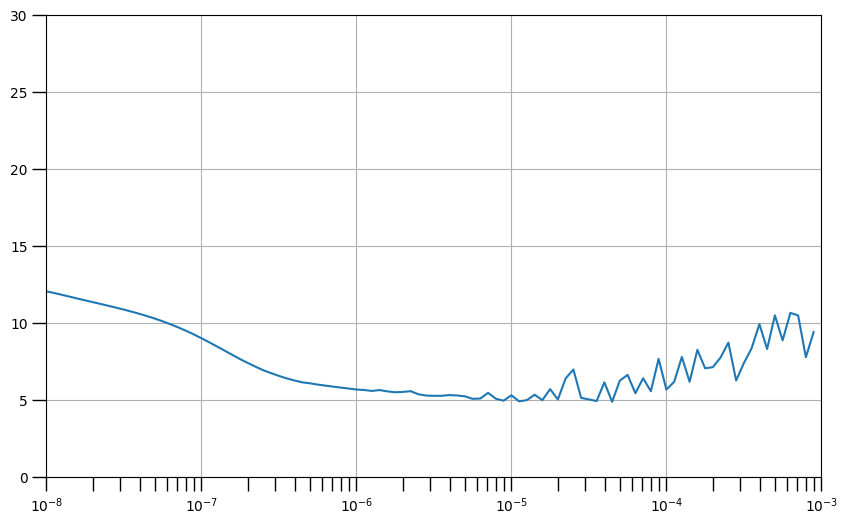

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch/20)
)

# Initialize the optimizer
optimizer  = tf.keras.optimizers.SGD(momentum = 0.9)

# Set the training parameters
model_tune.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer)

# Train the model
history = model_tune.fit(dataset, epochs = 100, callbacks = [lr_schedule])

# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100)/ 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

## Train the Model

You can then proceed to train the model with your chosen learning rate.

*Tip: When experimenting and you find yourself running different iterations of a model, you may want to use the [`clear_session()`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session) method to declutter memory used by Keras. This is added in the first line below.*


In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 8s 29ms/step - loss: 13.7213 - mae: 14.2131
Epoch 2/100
31/31 [==============================] - 1s 27ms/step - loss: 8.5768 - mae: 9.0643
Epoch 3/100
31/31 [==============================] - 1s 27ms/step - loss: 7.8577 - mae: 8.3421
Epoch 4/100
31/31 [==============================] - 1s 28ms/step - loss: 7.6131 - mae: 8.0967
Epoch 5/100
31/31 [==============================] - 1s 28ms/step - loss: 7.0803 - mae: 7.5639
Epoch 6/100
31/31 [==============================] - 2s 50ms/step - loss: 6.8773 - mae: 7.3637
Epoch 7/100
31/31 [==============================] - 1s 28ms/step - loss: 6.8493 - mae: 7.3350
Epoch 8/100
31/31 [==============================] - 1s 28ms/step - loss: 6.8089 - mae: 7.2942
Epoch 9/100
31/31 [==============================] - 1s 27ms/step - loss: 6.3886 - mae: 6.8692
Epoch 10/100
31/31 [==============================] - 1s 28ms/step - loss: 6.2543 - mae: 6.7400
Epoch 11/100
31/31 [===========================

## Model Prediction

You will then generate batches of windows to generate predictions that align with the validation set.

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

15/15 [==============================] - 2s 12ms/step


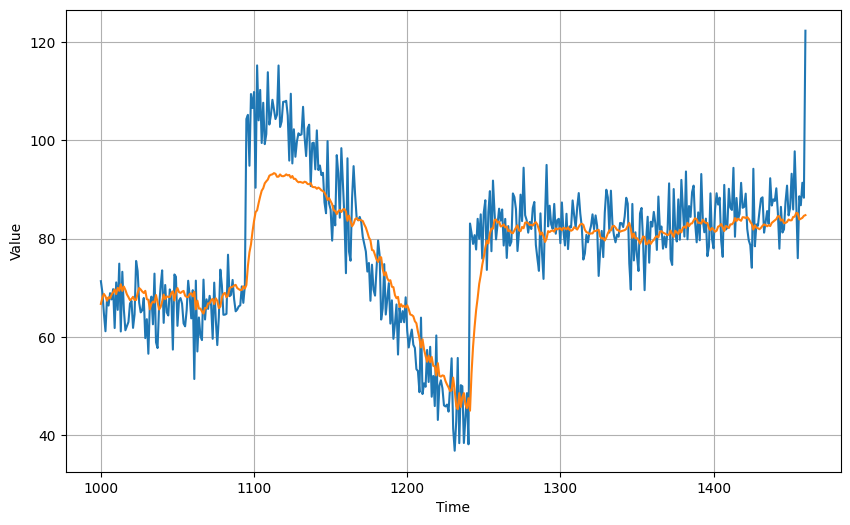

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then generate the metrics to evaluate the model's performance.

In [ ]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

64.24936
5.8193216


## Wrap Up

This concludes this short exercise on using LSTMs for time series forecasting. Next week, you will build upon this and add convolutions. Then, you will start to move away from synthetic data and use real-world datasets. See you there!

## Optional: Including a Validation Set while Training

Back in the first course of this specialization, you saw how you can also monitor the performance of your model against a validation set while training. You can also do that for this lab.

First, you need to generate a `val_set` which are data windows and labels that your model can accept. You can simply reuse the `windowed_dataset` function for that and you can pass in the `x_valid` points to generate the windows.

In [ ]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

You can then do the same training as before but pass in the `val_set` to the `validation_data` parameter of the `fit()` method.

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100, validation_data=val_set)

Epoch 1/100
31/31 [==============================] - 10s 89ms/step - loss: 24.0925 - mae: 24.5897 - val_loss: 31.8498 - val_mae: 32.3488
Epoch 2/100
31/31 [==============================] - 1s 38ms/step - loss: 9.2149 - mae: 9.7022 - val_loss: 20.6764 - val_mae: 21.1735
Epoch 3/100
31/31 [==============================] - 1s 38ms/step - loss: 7.1103 - mae: 7.5926 - val_loss: 16.8268 - val_mae: 17.3227
Epoch 4/100
31/31 [==============================] - 1s 33ms/step - loss: 6.8181 - mae: 7.2993 - val_loss: 15.2879 - val_mae: 15.7847
Epoch 5/100
31/31 [==============================] - 1s 37ms/step - loss: 6.5217 - mae: 7.0043 - val_loss: 14.2089 - val_mae: 14.7036
Epoch 6/100
31/31 [==============================] - 1s 42ms/step - loss: 6.2395 - mae: 6.7187 - val_loss: 13.2692 - val_mae: 13.7641
Epoch 7/100
31/31 [==============================] - 1s 38ms/step - loss: 6.1317 - mae: 6.6149 - val_loss: 11.1422 - val_mae: 11.6304
Epoch 8/100
31/31 [==============================] - 1s 33m

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Ungraded Lab: Using Convolutions with LSTMs

Welcome to the final week of this course! In this lab, you will build upon the RNN models you built last week and append a convolution layer to it. As you saw in previous courses, convolution filters can also capture features from sequences so it's good to try them out when exploring model architectures. Let's begin!

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

You will be plotting the MAE and loss later so the `plot_series()` is extended to have more labelling functionality. The utilities for generating the synthetic data is the same as the previous labs.

In [ ]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Generate the Synthetic Data

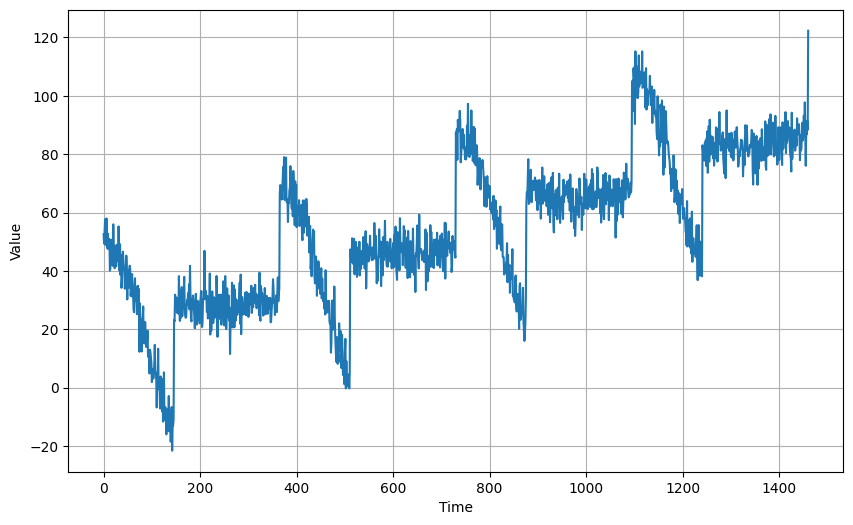

In [ ]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series, xlabel='Time', ylabel='Value')

## Split the Dataset

In [ ]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

As mentioned in the lectures, you can experiment with different batch sizing here and see how it affects your results.

In [ ]:
# Parameters
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

Here is the model architecture you will be using. It is very similar to the last RNN you built but with the [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer at the input. One important [argument](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D#args) here is the `padding`. For time series data, it is good practice to not let computations for a particular time step to be affected by values into the future. Here is one way of looking at it:

* Let's say you have a small time series window with these values: `[1, 2, 3, 4, 5]`. This means the value `1` is at `t=0`, `2` is at `t=1`, etc.
* If you have a 1D kernel of size `3`, then the first convolution will be for the values at `[1, 2, 3]` which are values for `t=0` to `t=2`.
* When you pass this to the first timestep of the `LSTM` after the convolution, it means that the value at `t=0` of the LSTM depends on `t=1` and `t=2` which are values into the future.
* For time series data, you want computations to only rely on current and previous time steps.
* One way to do that is to pad the array depending on the kernel size and stride. For a kernel size of 3 and stride of 1, the window can be padded as such: `[0, 0, 1, 2, 3, 4, 5]`. `1` is still at `t=0` and two zeroes are prepended to simulate values in the past.
* This way, the first stride will be at `[0, 0, 1]` and this does not contain any future values when it is passed on to subsequent layers.

The `Conv1D` layer does this kind of padding by setting `padding=causal` and you'll see that below.

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = 'causal', activation = 'relu', input_shape = [window_size, 1]),
    tf.keras.layers.LSTM(64, return_sequences= True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66369 (259.25 KB)
Trainable params: 66369 (259.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Tune the Learning Rate

In the previous labs, you are using different models for tuning and training. That is a valid approach but you can also use the same model for both. Before tuning, you can use the [`get_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#get_weights) method so you can reset it later.

In [ ]:
# Get initial weights
init_weights = model.get_weights()

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer)

# Train the Model
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
62/62 [==============================] - 6s 21ms/step - loss: 27.0470 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 1s 21ms/step - loss: 12.5511 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 1s 21ms/step - loss: 11.9095 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 3s 44ms/step - loss: 11.3903 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 3s 43ms/step - loss: 10.9719 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 4s 57ms/step - loss: 10.6799 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 3s 43ms/step - loss: 10.4853 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 2s 30ms/step - loss: 10.3422 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 2s 25ms/step - loss: 10.2528 - lr: 2.5119e-08
Epoch 10/100
62/62 [==============================] - 3s 49ms/step - loss: 10.1537 - lr: 2.8184e-08
Epoch 11/

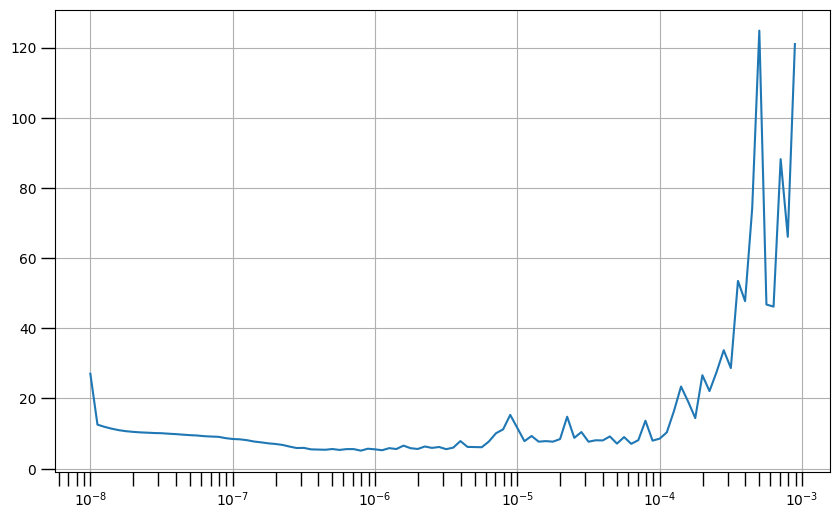

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) /20 ))

# Set the figure size
plt.figure(figsize = (10,6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history['loss'])

# Increase the tickmarks size
plt.tick_params('both', length = 10, width = 1, which = 'both')

## Train the Model

To reset the weights, you can simply call the [`set_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#set_weights) and pass in the saved weights from earlier.

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [ ]:
# Set the learning rate
learning_rate = 1e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Train the model
history = model.fit(train_set,epochs=500)

Epoch 1/500
62/62 [==============================] - 5s 22ms/step - loss: 16.5033 - mae: 16.9944
Epoch 2/500
62/62 [==============================] - 1s 22ms/step - loss: 10.2906 - mae: 10.7724
Epoch 3/500
62/62 [==============================] - 2s 24ms/step - loss: 9.9783 - mae: 10.4578
Epoch 4/500
62/62 [==============================] - 2s 23ms/step - loss: 9.7221 - mae: 10.2046
Epoch 5/500
62/62 [==============================] - 1s 21ms/step - loss: 9.3458 - mae: 9.8281
Epoch 6/500
62/62 [==============================] - 1s 21ms/step - loss: 9.0859 - mae: 9.5694
Epoch 7/500
62/62 [==============================] - 1s 21ms/step - loss: 8.8449 - mae: 9.3218
Epoch 8/500
62/62 [==============================] - 1s 21ms/step - loss: 8.6806 - mae: 9.1626
Epoch 9/500
62/62 [==============================] - 2s 23ms/step - loss: 8.4100 - mae: 8.8901
Epoch 10/500
62/62 [==============================] - 1s 20ms/step - loss: 8.1766 - mae: 8.6550
Epoch 11/500
62/62 [=======================

Training can be a bit unstable especially as the weights start to converge so you may want to visualize it to see if it is still trending down. The earlier epochs might dominate the graph so it's also good to zoom in on the later parts of training to properly observe the parameters. The code below visualizes the `mae` and `loss` for all epochs, and also zooms in at the last 80%.

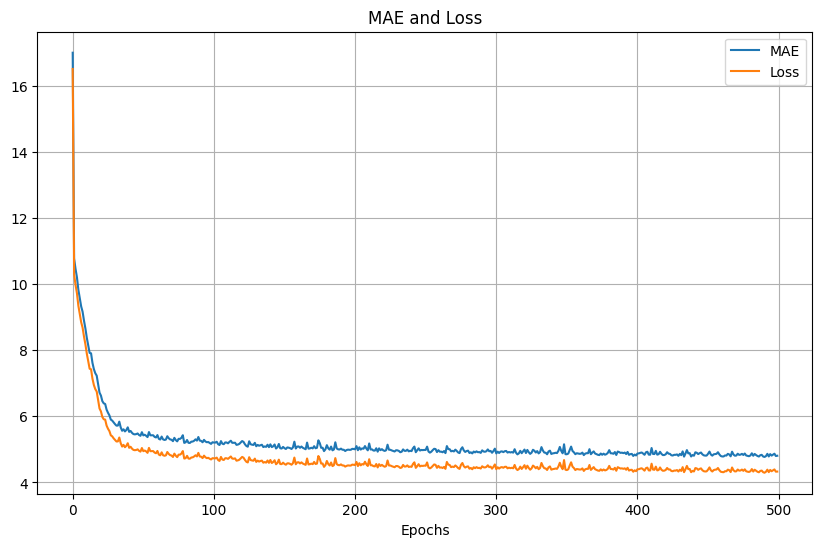

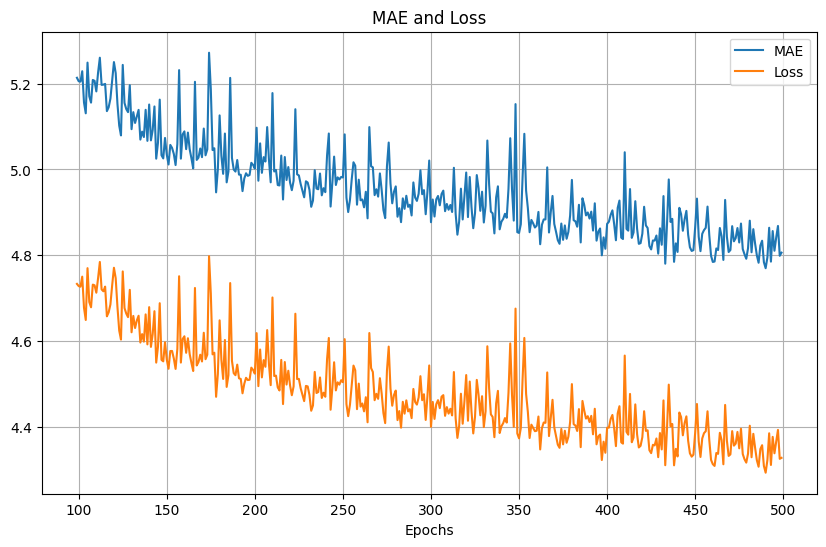

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

## Model Prediction

Once training is done, you can generate the model predictions and plot them against the validation set.


In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

29/29 [==============================] - 1s 8ms/step


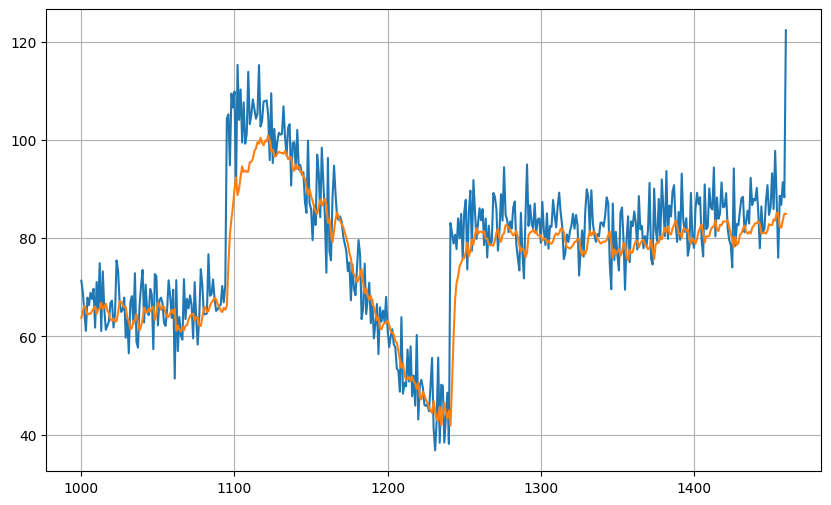

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

56.971134
5.4480457


## Wrap Up

In this lab, you were able to build and train a CNN-RNN model for forecasting. This concludes the series of notebooks on training with synthetic data. In the next labs, you will be looking at a real world time series dataset, particularly sunspot cycles. See you there!

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Ungraded Lab: Predicting Sunspots with Neural Networks (DNN only)

In the remaining labs for this week, you will move away from synthetic time series and start building models for real world data. In particular, you will train on the [Sunspots](https://www.kaggle.com/datasets/robervalt/sunspots) dataset: a monthly record of sunspot numbers from January 1749 to July 2018. You will first build a deep neural network here composed of dense layers. This will act as your baseline so you can compare it to the next lab where you will use a more complex architecture.

Let's begin!

## Imports

You will use the same imports as before with the addition of the [csv](https://docs.python.org/3/library/csv.html) module. You will need this to parse the CSV file containing the dataset.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

## Utilities

You will only have the `plot_series()` dataset here because you no longer need the synthetic data generation functions.

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

You can now download the dataset and inspect the contents. The link in class is from Laurence's repo but we also hosted it in the link below.

In [3]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-02-25 06:57:37--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.207, 173.194.213.207, 173.194.216.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2024-02-25 06:57:37 (100 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



Running the cell below, you'll see that there are only three columns in the dataset:
1. untitled column containing the month number
2. Date which has the format `YYYY-MM-DD`
3. Mean Total Sunspot Number

In [4]:
# Preview the dataset
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


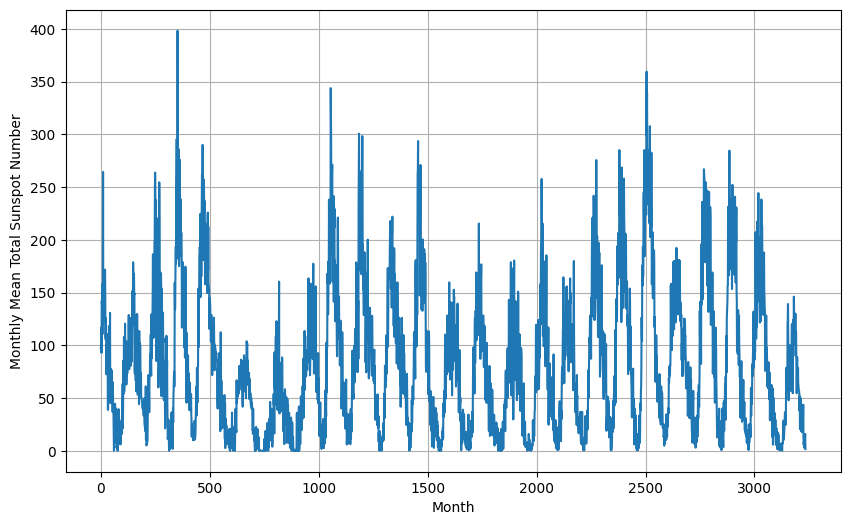

In [5]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter = ',')

  # Skip the forst line
  next(reader)

  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))


  # COnvert lists to numpy arrays
  time = np.array(time_step)
  series = np.array(sunspots)

  # Preview the data
  plot_series(
      time, series, xlabel = 'Month', ylabel = 'Monthly Mean Total Sunspot Number'
  )

## Split the Dataset

Next, you will split the dataset into training and validation sets. There are 3235 points in the dataset and you will use the first 3000 for training.

In [6]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

You can then prepare the dataset windows as before. The window size is set to 30 points (equal to 2.5 years) but feel free to change later on if you want to experiment.

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window te data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)

    # Flatten the windows y putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [8]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

The model will be 3-layer dense network as shown below.

In [9]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape =[window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1251 (4.89 KB)
Trainable params: 1251 (4.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Tune the Learning Rate

You can pick a learning rate by running the same learning rate scheduler code from previous labs.

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer)

# Train the model
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
93/93 [==============================] - 1s 6ms/step - loss: 130.1964 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 4ms/step - loss: 128.6886 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 5ms/step - loss: 126.9698 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 0s 4ms/step - loss: 125.0262 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 5ms/step - loss: 122.8233 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 0s 4ms/step - loss: 120.3327 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 1s 4ms/step - loss: 117.4972 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 1s 8ms/step - loss: 114.2890 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 9ms/step - loss: 110.6964 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 1s 4ms/step - loss: 106.6671 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 100.0)

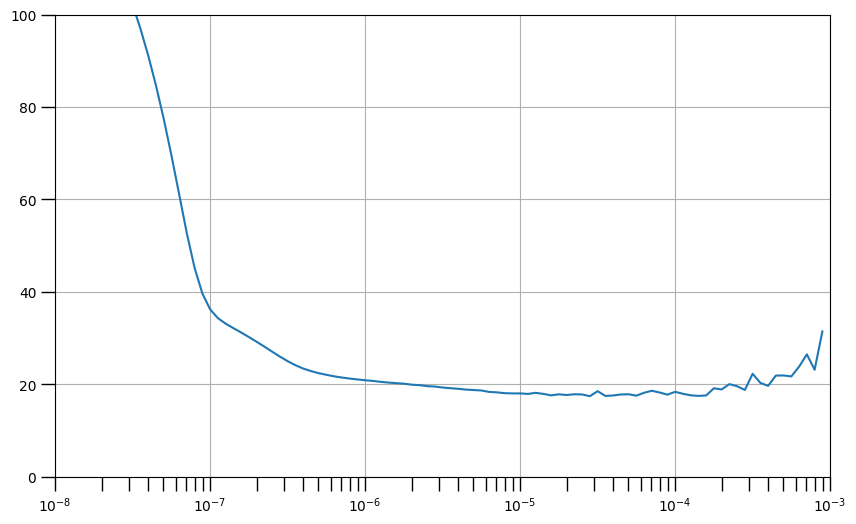

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Once you've picked a learning rate, you can rebuild the model and start training.

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape = [window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

# Set the training parameters
model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ['mae']
)

# Train the model
history = model.fit(train_set, epochs = 100)

Epoch 1/100
93/93 [==============================] - 2s 14ms/step - loss: 27.4405 - mae: 27.9354
Epoch 2/100
93/93 [==============================] - 1s 4ms/step - loss: 20.7320 - mae: 21.2246
Epoch 3/100
93/93 [==============================] - 1s 4ms/step - loss: 20.1602 - mae: 20.6535
Epoch 4/100
93/93 [==============================] - 1s 4ms/step - loss: 19.0087 - mae: 19.5008
Epoch 5/100
93/93 [==============================] - 1s 4ms/step - loss: 18.6865 - mae: 19.1786
Epoch 6/100
93/93 [==============================] - 0s 4ms/step - loss: 18.2834 - mae: 18.7755
Epoch 7/100
93/93 [==============================] - 1s 4ms/step - loss: 18.4164 - mae: 18.9094
Epoch 8/100
93/93 [==============================] - 1s 4ms/step - loss: 18.5636 - mae: 19.0567
Epoch 9/100
93/93 [==============================] - 1s 4ms/step - loss: 17.8114 - mae: 18.3047
Epoch 10/100
93/93 [==============================] - 1s 5ms/step - loss: 17.9859 - mae: 18.4786
Epoch 11/100
93/93 [==================

## Model Prediction

Now see if the model generates good results. If you used the default parameters of this notebook, you should see the predictions follow the shape of the ground truth with an MAE of around 15.

In [19]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset  = tf.data.Dataset.from_tensor_slices(series)

    # window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift = 1, drop_remainder = True)

    # Flatten the windows by puttings its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

8/8 [==============================] - 0s 6ms/step


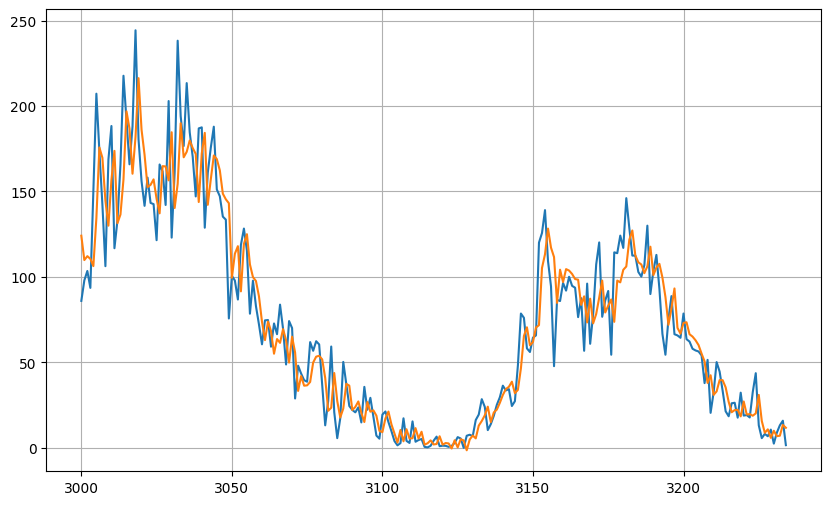

In [20]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [21]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.594253


## Wrap Up

In this lab, you built a relatively simple DNN to forecast sunspot numbers for a given month. We encourage you to tweak the parameters or train longer and see the best results you can get. In the next lab, you will build a more complex model and you evaluate if the added complexity translates to better or worse results.

---------------------------------------------------------------------------------------------------------------------------

# Ungraded Lab: Predicting Sunspots with Neural Networks

At this point in the course, you should be able to explore different network architectures for forecasting. In the previous weeks, you've used DNNs, RNNs, and CNNs to build these different models. In the final practice lab for this course, you'll try one more configuration and that is a combination of all these types of networks: the data windows will pass through a convolution, followed by stacked LSTMs, followed by stacked dense layers. See if this improves results or you can just opt for simpler models.

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

## Utilities

In [16]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

In [17]:
# Download the Dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-02-25 07:12:43--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.207, 173.194.215.207, 173.194.216.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv.1’

Sunspots.csv.1      100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2024-02-25 07:12:43 (89.4 MB/s) - ‘Sunspots.csv.1’ saved [70827/70827]



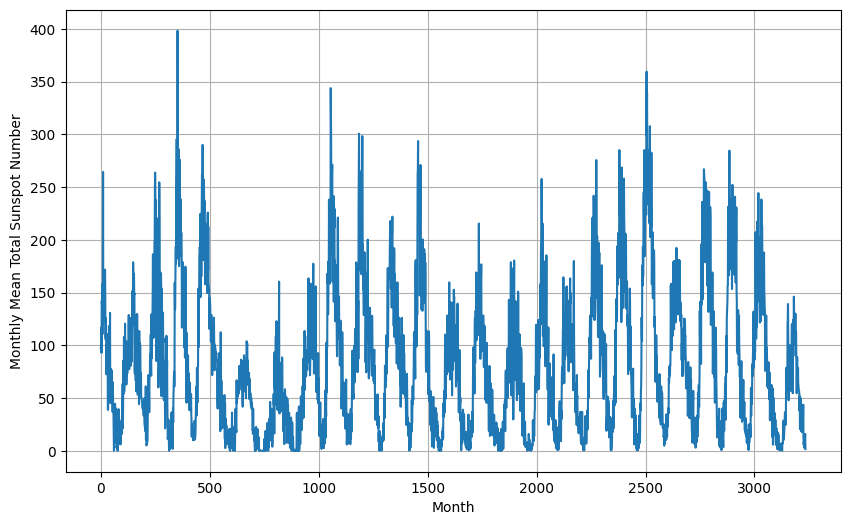

In [18]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

## Split the Dataset

In [22]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [28]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """Generates dataset windows

  Args:
    series (array of float) - contains the values of the time series
    window_size (int) - the number of time steps to include in the feature
    batch_size (int) - the batch size
    shuffle_buffer(int) - buffer size to use for the shuffle method

  Returns:
    dataset (TF Dataset) - TF Dataset containing time windows
    """
  dataset = tf.data.Dataset.from_tensor_slices(series)


  # Generate a TF Dataset from the series values


  # Window the data but only take those with the specified size
  dataset = dataset.window(window_size + 1, shift  = 1, drop_remainder = True)

  # Flatten the window by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size +1))

  # Create tuples with features and labels
  dataset = dataset.map(lambda window : (window[:-1], window[-1]))

  # Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)

  # Crate batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

As mentioned in the lectures, if your results don't look good, you can try tweaking the parameters here and see if the model will learn better.

In [29]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

You've seen these layers before and here is how it looks like when combined.

In [32]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(
        filters = 64, kernel_size = 3,
        strides = 1,
        activation = 'relu',
        padding = 'causal',
        input_shape = [window_size, 1]
    ),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x* 400)
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 30, 64)            256       
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 30)                1950      
                                                                 
 dense_7 (Dense)             (None, 10)                310       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                

## Tune the Learning Rate

As usual, you will want to pick an optimal learning rate.

In [33]:
# Get the initial weights
init_weights = model.get_weights()

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10**(epoch/20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(), optimizer  = optimizer)

# Train the model
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
93/93 [==============================] - 12s 54ms/step - loss: 41.8532 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 6s 56ms/step - loss: 33.6100 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 7s 71ms/step - loss: 30.7413 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 6s 55ms/step - loss: 28.8654 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 5s 49ms/step - loss: 27.3864 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 4s 39ms/step - loss: 26.1491 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 4s 38ms/step - loss: 24.9611 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 4s 40ms/step - loss: 23.9429 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 4s 38ms/step - loss: 23.0537 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 7s 74ms/step - loss: 22.3481 - lr: 2.8184e-08
Epoch 11

(1e-08, 0.001, 0.0, 100.0)

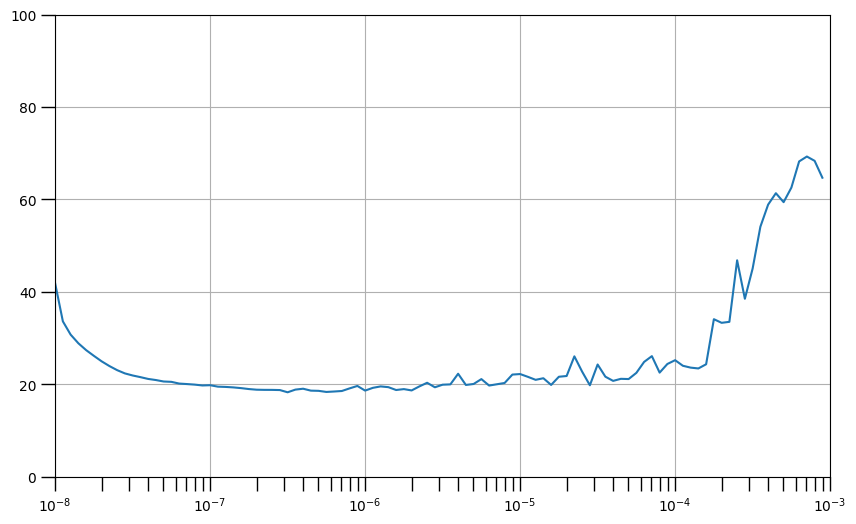

In [37]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below but feel free to increase it if you want. Laurence got his results in the lectures after 500.

In [41]:
# Reset the states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [42]:
# Set the learning rate
learning_rate = 8e-7

# Set the optizer
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae']
)

In [43]:
# Train the model
history = model.fit(train_set, epochs = 100)

Epoch 1/100
93/93 [==============================] - 7s 39ms/step - loss: 24.0951 - mae: 24.5894
Epoch 2/100
93/93 [==============================] - 5s 51ms/step - loss: 20.5952 - mae: 21.0881
Epoch 3/100
93/93 [==============================] - 4s 38ms/step - loss: 19.2669 - mae: 19.7591
Epoch 4/100
93/93 [==============================] - 4s 43ms/step - loss: 19.1443 - mae: 19.6376
Epoch 5/100
93/93 [==============================] - 4s 38ms/step - loss: 18.5179 - mae: 19.0113
Epoch 6/100
93/93 [==============================] - 4s 38ms/step - loss: 18.9711 - mae: 19.4641
Epoch 7/100
93/93 [==============================] - 4s 46ms/step - loss: 18.8528 - mae: 19.3469
Epoch 8/100
93/93 [==============================] - 4s 41ms/step - loss: 18.4908 - mae: 18.9831
Epoch 9/100
93/93 [==============================] - 4s 38ms/step - loss: 19.3744 - mae: 19.8664
Epoch 10/100
93/93 [==============================] - 5s 51ms/step - loss: 18.9673 - mae: 19.4609
Epoch 11/100
93/93 [=========

You can visualize the training and see if the loss and MAE are still trending down.

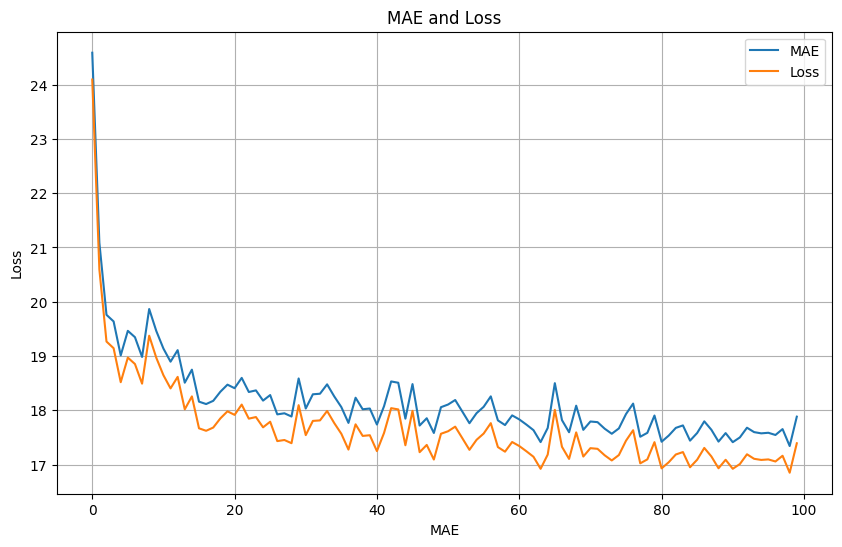

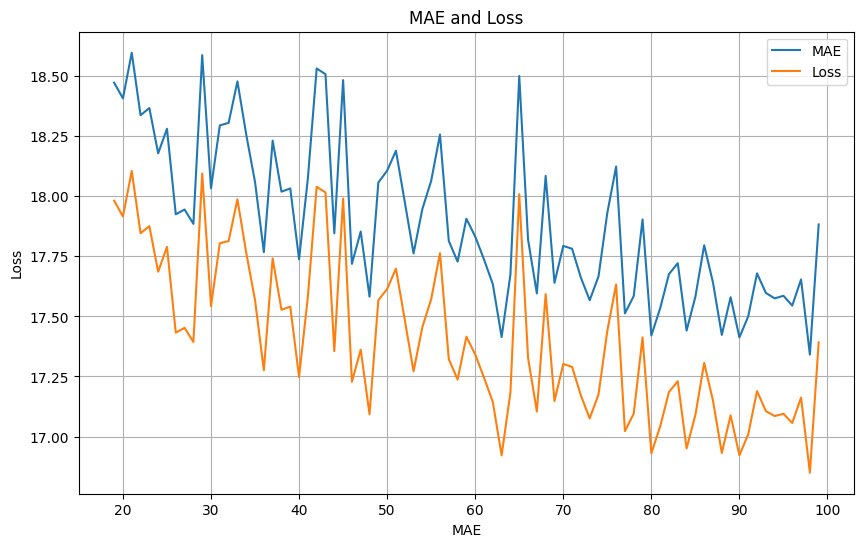

In [44]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction

As before, you can get the predictions for the validation set time range and compute the metrics.

In [38]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

8/8 [==============================] - 2s 24ms/step


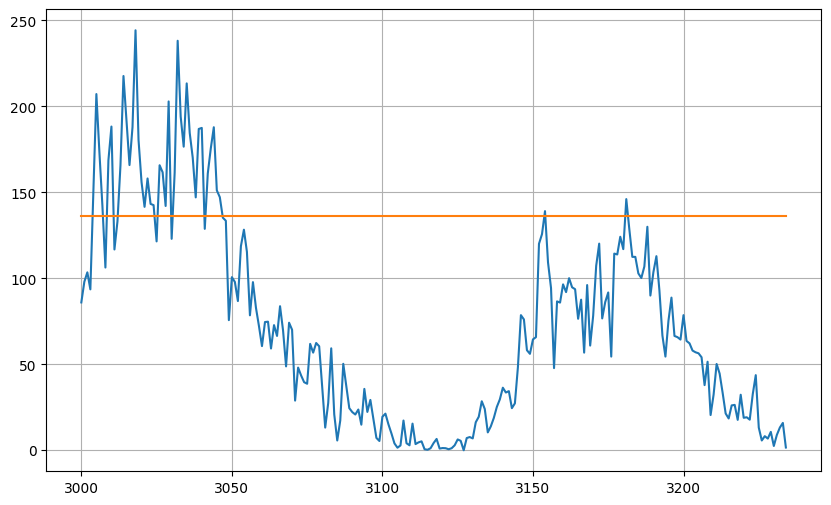

In [39]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [40]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

75.58233


## Wrap Up

This concludes the final practice lab for this course! You implemented a deep and complex architecture composed of CNNs, RNNs, and DNNs. You'll be using the skills you developed throughout this course to complete the final assignment. Keep it up!

---------------------------------------------------------------------------------------------------------------------------